Mounted at /content/drive
Google Drive mounted successfully.
Starting magnification-aware cell counting with distribution analysis...

Processing folder: flow3-x20
Found 8 TIF file(s)

Processing folder: 1.4Pa-x40
Found 13 TIF file(s)

Processing folder: 1.4Pa-x20
Found 23 TIF file(s)

CREATING DISTRIBUTION PLOTS


/tmp/ipython-input-1-2548470672.py:127: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels)
/tmp/ipython-input-1-2548470672.py:136: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data_density, labels=box_labels)


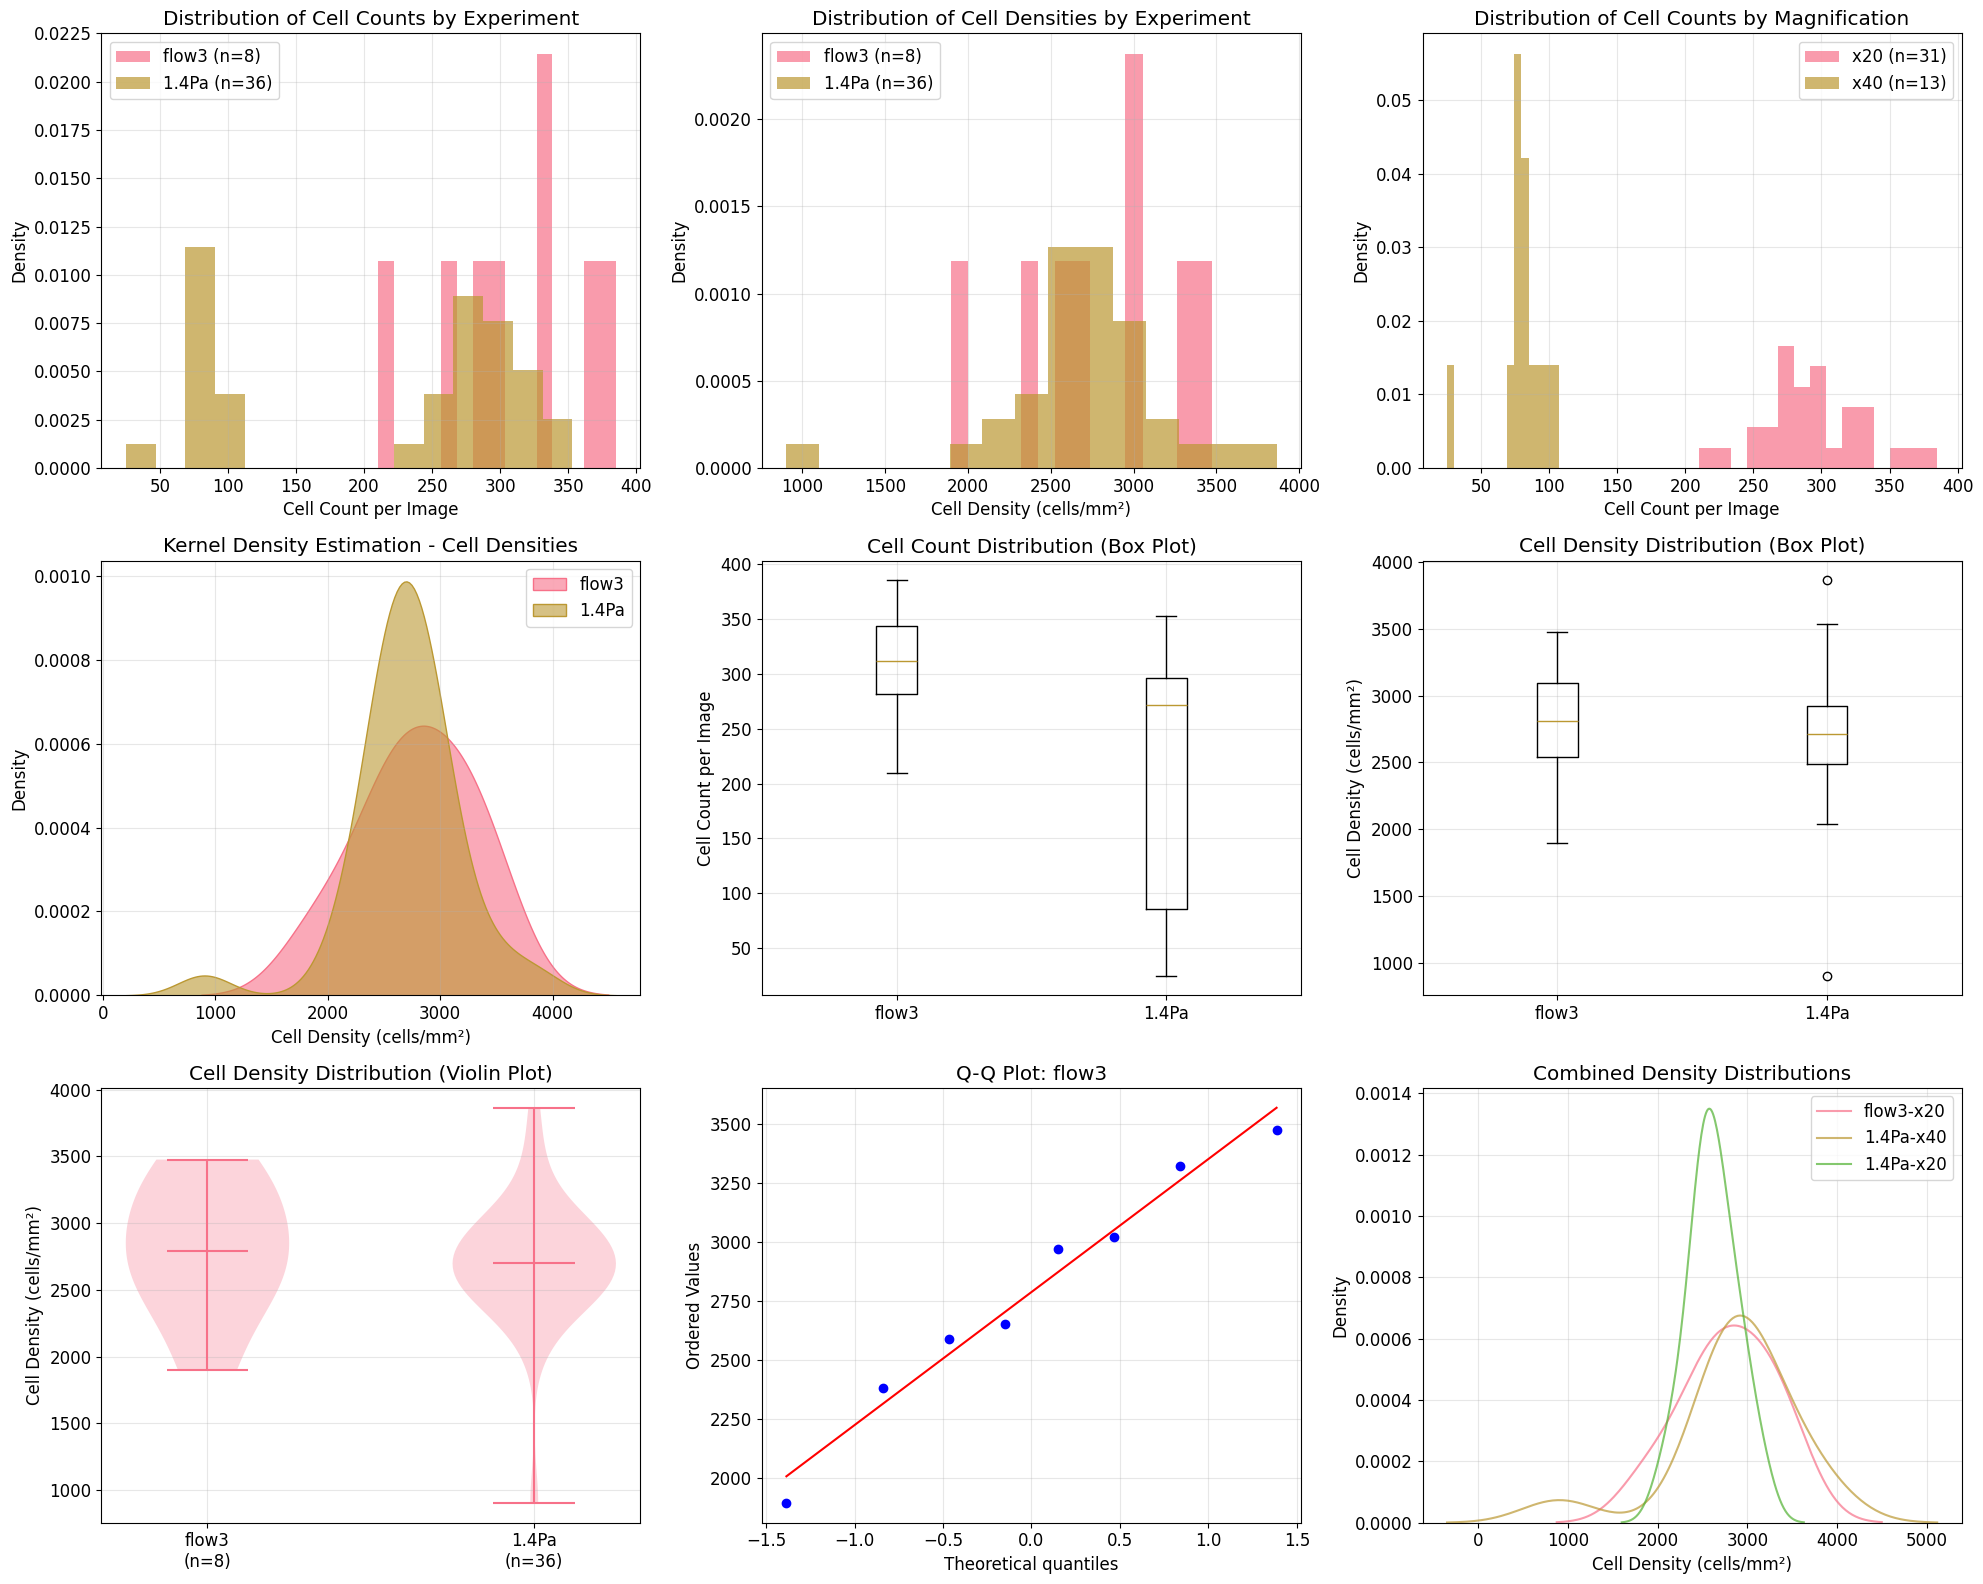

Comprehensive distribution plots saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/cell_distribution_analysis_comprehensive.png


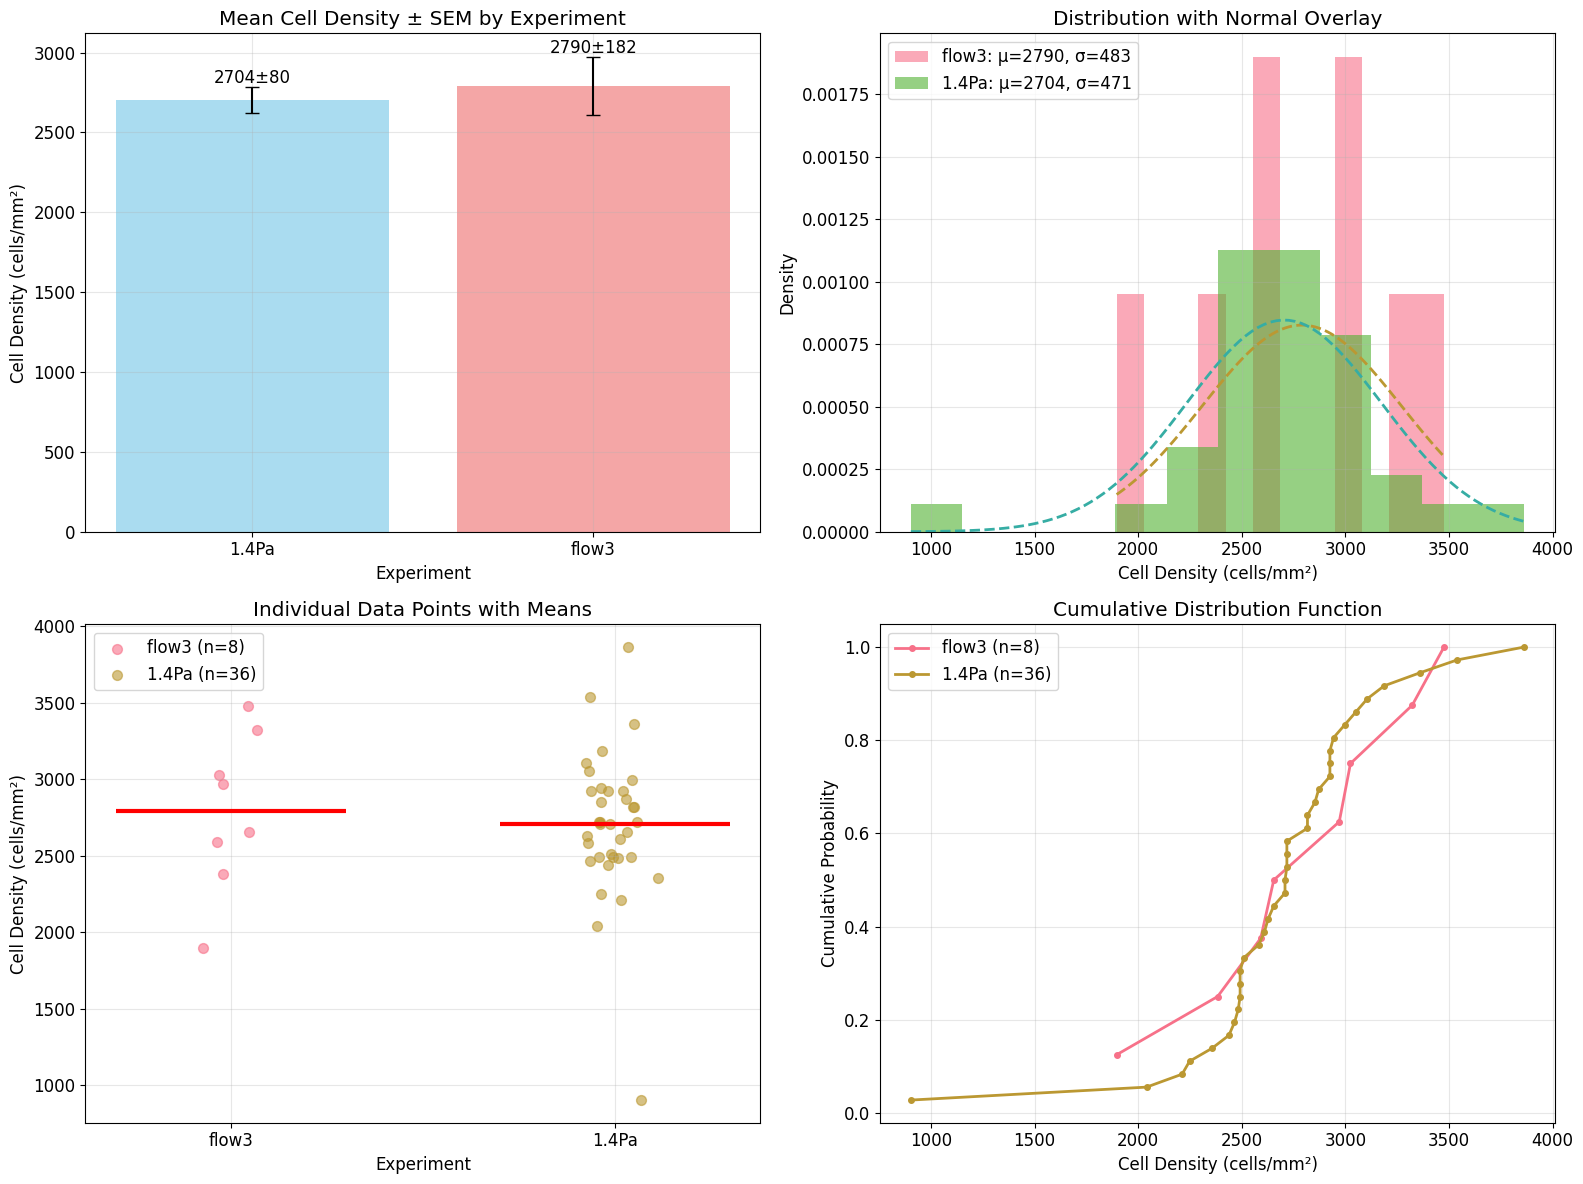

Statistical summary plots saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/cell_statistical_summary_plots.png

DISTRIBUTION STATISTICS SUMMARY

FLOW3 EXPERIMENT:
  Sample size: 8
  Mean: 2789.9 cells/mm²
  Median: 2812.5 cells/mm²
  Std Dev: 482.7 cells/mm²
  Min: 1896.1 cells/mm²
  Max: 3476.1 cells/mm²
  25th percentile: 2539.4 cells/mm²
  75th percentile: 3099.2 cells/mm²
  Normality test (Shapiro-Wilk): p = 0.9202
    → Data appears normally distributed (p > 0.05)

1.4PA EXPERIMENT:
  Sample size: 36
  Mean: 2704.4 cells/mm²
  Median: 2713.2 cells/mm²
  Std Dev: 471.2 cells/mm²
  Min: 902.9 cells/mm²
  Max: 3864.4 cells/mm²
  25th percentile: 2492.0 cells/mm²
  75th percentile: 2925.4 cells/mm²
  Normality test (Shapiro-Wilk): p = 0.0022
    → Data may not be normally distributed (p ≤ 0.05)

STATISTICAL COMPARISON BETWEEN EXPERIMENTS:
  T-test p-value: 0.6538
  Effect size (Cohen's d): 0.177
  Mann-Whitney U test p-value: 0.6262

DISTRIBUTION ANALYSIS COMP

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Define magnification-specific parameters
MAGNIFICATION_PARAMS = {
    'x20': {
        'pixel_size_um': 0.325,
        'field_of_view_um2': None,
        'theoretical_fov_mm2': 1.0,
    },
    'x40': {
        'pixel_size_um': 0.1625,
        'field_of_view_um2': None,
        'theoretical_fov_mm2': 0.25,
    }
}

def count_cells_in_segmentation_tif(tif_path):
    """Count the number of segmented cells in a TIF file."""
    try:
        img = Image.open(tif_path)
        img_array = np.array(img)
        unique_labels = np.unique(img_array)
        cell_labels = unique_labels[unique_labels > 0]
        cell_count = len(cell_labels)
        height, width = img_array.shape[:2]
        return cell_count, width, height, img_array.dtype
    except Exception as e:
        try:
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None, None, None, None
            unique_labels = np.unique(img_array)
            cell_labels = unique_labels[unique_labels > 0]
            cell_count = len(cell_labels)
            height, width = img_array.shape[:2]
            return cell_count, width, height, img_array.dtype
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None, None, None, None

def calculate_field_area(width, height, pixel_size_um):
    """Calculate the actual field area in μm²"""
    width_um = width * pixel_size_um
    height_um = height * pixel_size_um
    area_um2 = width_um * height_um
    return area_um2, width_um, height_um

def create_distribution_plots(detailed_df, base_path):
    """Create comprehensive distribution plots for cell analysis"""

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # Plot 1: Cell Count Distribution by Experiment
    plt.subplot(3, 3, 1)
    for exp in detailed_df['experiment'].unique():
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_count']
        plt.hist(exp_data, alpha=0.7, label=f'{exp} (n={len(exp_data)})', bins=15, density=True)
    plt.xlabel('Cell Count per Image')
    plt.ylabel('Density')
    plt.title('Distribution of Cell Counts by Experiment')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Cell Density Distribution by Experiment
    plt.subplot(3, 3, 2)
    for exp in detailed_df['experiment'].unique():
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']
        plt.hist(exp_data, alpha=0.7, label=f'{exp} (n={len(exp_data)})', bins=15, density=True)
    plt.xlabel('Cell Density (cells/mm²)')
    plt.ylabel('Density')
    plt.title('Distribution of Cell Densities by Experiment')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Cell Count Distribution by Magnification
    plt.subplot(3, 3, 3)
    for mag in detailed_df['magnification'].unique():
        mag_data = detailed_df[detailed_df['magnification'] == mag]['cell_count']
        plt.hist(mag_data, alpha=0.7, label=f'{mag} (n={len(mag_data)})', bins=15, density=True)
    plt.xlabel('Cell Count per Image')
    plt.ylabel('Density')
    plt.title('Distribution of Cell Counts by Magnification')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 4: Kernel Density Estimation for Cell Densities
    plt.subplot(3, 3, 4)
    for exp in detailed_df['experiment'].unique():
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']
        if len(exp_data) > 1:  # Need at least 2 points for KDE
            sns.kdeplot(data=exp_data, label=f'{exp}', fill=True, alpha=0.6)
    plt.xlabel('Cell Density (cells/mm²)')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation - Cell Densities')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: Box plots for Cell Counts
    plt.subplot(3, 3, 5)
    box_data = [detailed_df[detailed_df['experiment'] == exp]['cell_count'].values
                for exp in detailed_df['experiment'].unique()]
    box_labels = detailed_df['experiment'].unique()
    plt.boxplot(box_data, labels=box_labels)
    plt.ylabel('Cell Count per Image')
    plt.title('Cell Count Distribution (Box Plot)')
    plt.grid(True, alpha=0.3)

    # Plot 6: Box plots for Cell Densities
    plt.subplot(3, 3, 6)
    box_data_density = [detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2'].values
                       for exp in detailed_df['experiment'].unique()]
    plt.boxplot(box_data_density, labels=box_labels)
    plt.ylabel('Cell Density (cells/mm²)')
    plt.title('Cell Density Distribution (Box Plot)')
    plt.grid(True, alpha=0.3)

    # Plot 7: Violin plots for Cell Densities
    plt.subplot(3, 3, 7)
    violin_data = []
    violin_labels = []
    for exp in detailed_df['experiment'].unique():
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']
        violin_data.append(exp_data)
        violin_labels.append(f'{exp}\n(n={len(exp_data)})')

    parts = plt.violinplot(violin_data, positions=range(1, len(violin_data) + 1), showmeans=True)
    plt.xticks(range(1, len(violin_labels) + 1), violin_labels)
    plt.ylabel('Cell Density (cells/mm²)')
    plt.title('Cell Density Distribution (Violin Plot)')
    plt.grid(True, alpha=0.3)

    # Plot 8: Q-Q plots for normality check
    plt.subplot(3, 3, 8)
    for i, exp in enumerate(detailed_df['experiment'].unique()):
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']
        if len(exp_data) > 3:  # Need sufficient data for Q-Q plot
            stats.probplot(exp_data, dist="norm", plot=plt)
            plt.title(f'Q-Q Plot: {exp}')
            plt.grid(True, alpha=0.3)
            break  # Show only first experiment's Q-Q plot

    # Plot 9: Combined density comparison
    plt.subplot(3, 3, 9)
    combined_data = []
    combined_labels = []
    for exp in detailed_df['experiment'].unique():
        for mag in detailed_df[detailed_df['experiment'] == exp]['magnification'].unique():
            subset = detailed_df[(detailed_df['experiment'] == exp) &
                               (detailed_df['magnification'] == mag)]['cell_density_per_mm2']
            if len(subset) > 0:
                combined_data.append(subset.values)
                combined_labels.append(f'{exp}-{mag}')

    for i, (data, label) in enumerate(zip(combined_data, combined_labels)):
        if len(data) > 1:
            sns.kdeplot(data, label=label, alpha=0.7)

    plt.xlabel('Cell Density (cells/mm²)')
    plt.ylabel('Density')
    plt.title('Combined Density Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the comprehensive plot
    plot_path = os.path.join(base_path, "cell_distribution_analysis_comprehensive.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_path

def create_statistical_summary_plots(detailed_df, base_path):
    """Create statistical summary plots"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Mean ± SEM by experiment
    exp_stats = detailed_df.groupby('experiment')['cell_density_per_mm2'].agg(['mean', 'sem', 'std']).reset_index()

    ax1 = axes[0, 0]
    x_pos = range(len(exp_stats))
    bars = ax1.bar(x_pos, exp_stats['mean'], yerr=exp_stats['sem'],
                   capsize=5, alpha=0.7, color=['skyblue', 'lightcoral'][:len(exp_stats)])
    ax1.set_xlabel('Experiment')
    ax1.set_ylabel('Cell Density (cells/mm²)')
    ax1.set_title('Mean Cell Density ± SEM by Experiment')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(exp_stats['experiment'])
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar, mean_val, sem_val) in enumerate(zip(bars, exp_stats['mean'], exp_stats['sem'])):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + sem_val,
                f'{mean_val:.0f}±{sem_val:.0f}', ha='center', va='bottom')

    # Plot 2: Distribution comparison with statistics
    ax2 = axes[0, 1]
    for exp in detailed_df['experiment'].unique():
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']
        mean_val = np.mean(exp_data)
        std_val = np.std(exp_data)

        # Plot histogram
        ax2.hist(exp_data, alpha=0.6, label=f'{exp}: μ={mean_val:.0f}, σ={std_val:.0f}',
                bins=12, density=True)

        # Plot normal curve overlay
        x_norm = np.linspace(exp_data.min(), exp_data.max(), 100)
        y_norm = stats.norm.pdf(x_norm, mean_val, std_val)
        ax2.plot(x_norm, y_norm, '--', linewidth=2)

    ax2.set_xlabel('Cell Density (cells/mm²)')
    ax2.set_ylabel('Density')
    ax2.set_title('Distribution with Normal Overlay')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Individual data points with mean
    ax3 = axes[1, 0]
    for i, exp in enumerate(detailed_df['experiment'].unique()):
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']

        # Jitter the x-coordinates for better visualization
        x_jittered = np.random.normal(i, 0.05, len(exp_data))
        ax3.scatter(x_jittered, exp_data, alpha=0.6, s=50, label=f'{exp} (n={len(exp_data)})')

        # Plot mean line
        mean_val = np.mean(exp_data)
        ax3.hlines(mean_val, i-0.3, i+0.3, colors='red', linewidth=3)

    ax3.set_xlabel('Experiment')
    ax3.set_ylabel('Cell Density (cells/mm²)')
    ax3.set_title('Individual Data Points with Means')
    ax3.set_xticks(range(len(detailed_df['experiment'].unique())))
    ax3.set_xticklabels(detailed_df['experiment'].unique())
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Cumulative distribution function
    ax4 = axes[1, 1]
    for exp in detailed_df['experiment'].unique():
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']
        sorted_data = np.sort(exp_data)
        cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax4.plot(sorted_data, cumulative, marker='o', linestyle='-',
                label=f'{exp} (n={len(exp_data)})', linewidth=2, markersize=4)

    ax4.set_xlabel('Cell Density (cells/mm²)')
    ax4.set_ylabel('Cumulative Probability')
    ax4.set_title('Cumulative Distribution Function')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the statistical summary plot
    stat_plot_path = os.path.join(base_path, "cell_statistical_summary_plots.png")
    plt.savefig(stat_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return stat_plot_path

# Main analysis code (same as before)
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
folders = ["flow3-x20", "1.4Pa-x40", "1.4Pa-x20"]
subfolder_name = "Cell_merged_conservative"
detailed_results = []

print("Starting magnification-aware cell counting with distribution analysis...")

# Process each folder (keeping the original processing logic)
for folder in folders:
    folder_path = os.path.join(base_path, folder, subfolder_name)
    print(f"\nProcessing folder: {folder}")

    if not os.path.exists(folder_path):
        print(f"Warning: Path '{folder_path}' not found. Skipping.")
        continue

    tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

    if not tif_files:
        print(f"No TIF files found in {folder_path}")
        continue

    print(f"Found {len(tif_files)} TIF file(s)")

    # Extract experiment parameters
    if "flow3" in folder:
        pressure = '0Pa'
        experiment = 'flow3'
    elif "1.4Pa" in folder:
        pressure = '1.4Pa'
        experiment = '1.4Pa'
    else:
        pressure = 'Unknown'
        experiment = 'Unknown'

    if "x40" in folder:
        magnification = 'x40'
    elif "x20" in folder:
        magnification = 'x20'
    else:
        magnification = 'unknown'

    mag_params = MAGNIFICATION_PARAMS.get(magnification, {})
    pixel_size_um = mag_params.get('pixel_size_um', 1.0)

    # Process each TIF file
    for tif_file in tif_files:
        file_name = os.path.basename(tif_file)
        cell_count, width, height, dtype = count_cells_in_segmentation_tif(tif_file)

        if cell_count is not None:
            area_um2, width_um, height_um = calculate_field_area(width, height, pixel_size_um)
            area_mm2 = area_um2 / 1e6
            cell_density_per_mm2 = cell_count / area_mm2 if area_mm2 > 0 else 0

            detailed_results.append({
                'experiment': experiment,
                'pressure': pressure,
                'magnification': magnification,
                'folder': folder,
                'file': file_name,
                'cell_count': cell_count,
                'width_pixels': width,
                'height_pixels': height,
                'pixel_size_um': pixel_size_um,
                'field_area_um2': area_um2,
                'field_area_mm2': area_mm2,
                'cell_density_per_mm2': cell_density_per_mm2,
                'file_path': tif_file
            })

# Create distribution analysis if we have results
if detailed_results:
    detailed_df = pd.DataFrame(detailed_results)

    print("\n" + "="*80)
    print("CREATING DISTRIBUTION PLOTS")
    print("="*80)

    # Create comprehensive distribution plots
    plot1_path = create_distribution_plots(detailed_df, base_path)
    print(f"Comprehensive distribution plots saved: {plot1_path}")

    # Create statistical summary plots
    plot2_path = create_statistical_summary_plots(detailed_df, base_path)
    print(f"Statistical summary plots saved: {plot2_path}")

    # Print summary statistics
    print("\n" + "="*60)
    print("DISTRIBUTION STATISTICS SUMMARY")
    print("="*60)

    for exp in detailed_df['experiment'].unique():
        exp_data = detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2']
        print(f"\n{exp.upper()} EXPERIMENT:")
        print(f"  Sample size: {len(exp_data)}")
        print(f"  Mean: {np.mean(exp_data):.1f} cells/mm²")
        print(f"  Median: {np.median(exp_data):.1f} cells/mm²")
        print(f"  Std Dev: {np.std(exp_data):.1f} cells/mm²")
        print(f"  Min: {np.min(exp_data):.1f} cells/mm²")
        print(f"  Max: {np.max(exp_data):.1f} cells/mm²")
        print(f"  25th percentile: {np.percentile(exp_data, 25):.1f} cells/mm²")
        print(f"  75th percentile: {np.percentile(exp_data, 75):.1f} cells/mm²")

        # Test for normality
        if len(exp_data) >= 8:  # Minimum for Shapiro-Wilk test
            shapiro_stat, shapiro_p = stats.shapiro(exp_data)
            print(f"  Normality test (Shapiro-Wilk): p = {shapiro_p:.4f}")
            if shapiro_p > 0.05:
                print(f"    → Data appears normally distributed (p > 0.05)")
            else:
                print(f"    → Data may not be normally distributed (p ≤ 0.05)")

    # Statistical comparison between experiments
    if len(detailed_df['experiment'].unique()) >= 2:
        print(f"\nSTATISTICAL COMPARISON BETWEEN EXPERIMENTS:")
        exp_groups = [detailed_df[detailed_df['experiment'] == exp]['cell_density_per_mm2'].values
                     for exp in detailed_df['experiment'].unique()]

        # T-test
        if len(exp_groups) == 2:
            t_stat, t_p = stats.ttest_ind(exp_groups[0], exp_groups[1])
            print(f"  T-test p-value: {t_p:.4f}")

            # Effect size (Cohen's d)
            pooled_std = np.sqrt(((len(exp_groups[0]) - 1) * np.var(exp_groups[0], ddof=1) +
                                (len(exp_groups[1]) - 1) * np.var(exp_groups[1], ddof=1)) /
                               (len(exp_groups[0]) + len(exp_groups[1]) - 2))
            cohens_d = (np.mean(exp_groups[0]) - np.mean(exp_groups[1])) / pooled_std
            print(f"  Effect size (Cohen's d): {cohens_d:.3f}")

        # Mann-Whitney U test (non-parametric alternative)
        if len(exp_groups) == 2:
            u_stat, u_p = stats.mannwhitneyu(exp_groups[0], exp_groups[1], alternative='two-sided')
            print(f"  Mann-Whitney U test p-value: {u_p:.4f}")

    print(f"\n" + "="*80)
    print("DISTRIBUTION ANALYSIS COMPLETE")
    print("="*80)
    print("Two comprehensive plot files have been created:")
    print(f"1. {plot1_path}")
    print(f"2. {plot2_path}")

else:
    print("No data found to create distribution plots.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting individual cell area analysis...

Processing folder: flow3-x20
Found 8 TIF file(s)
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
    Found 329 cells
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
    Found 368 cells
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif
    Found 385 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq001_cell_mask_merged_conservative.tif
    Found 264 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq002_cell_mask_merged_conservative.tif
    Found 210 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq003_cell_mask_merged_conservative.tif
    Found 294 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq004_cell_mask_merged_conservative.tif
    Found 287 cells
  Processing: 1.4Pa

/tmp/ipython-input-2-861978332.py:136: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)


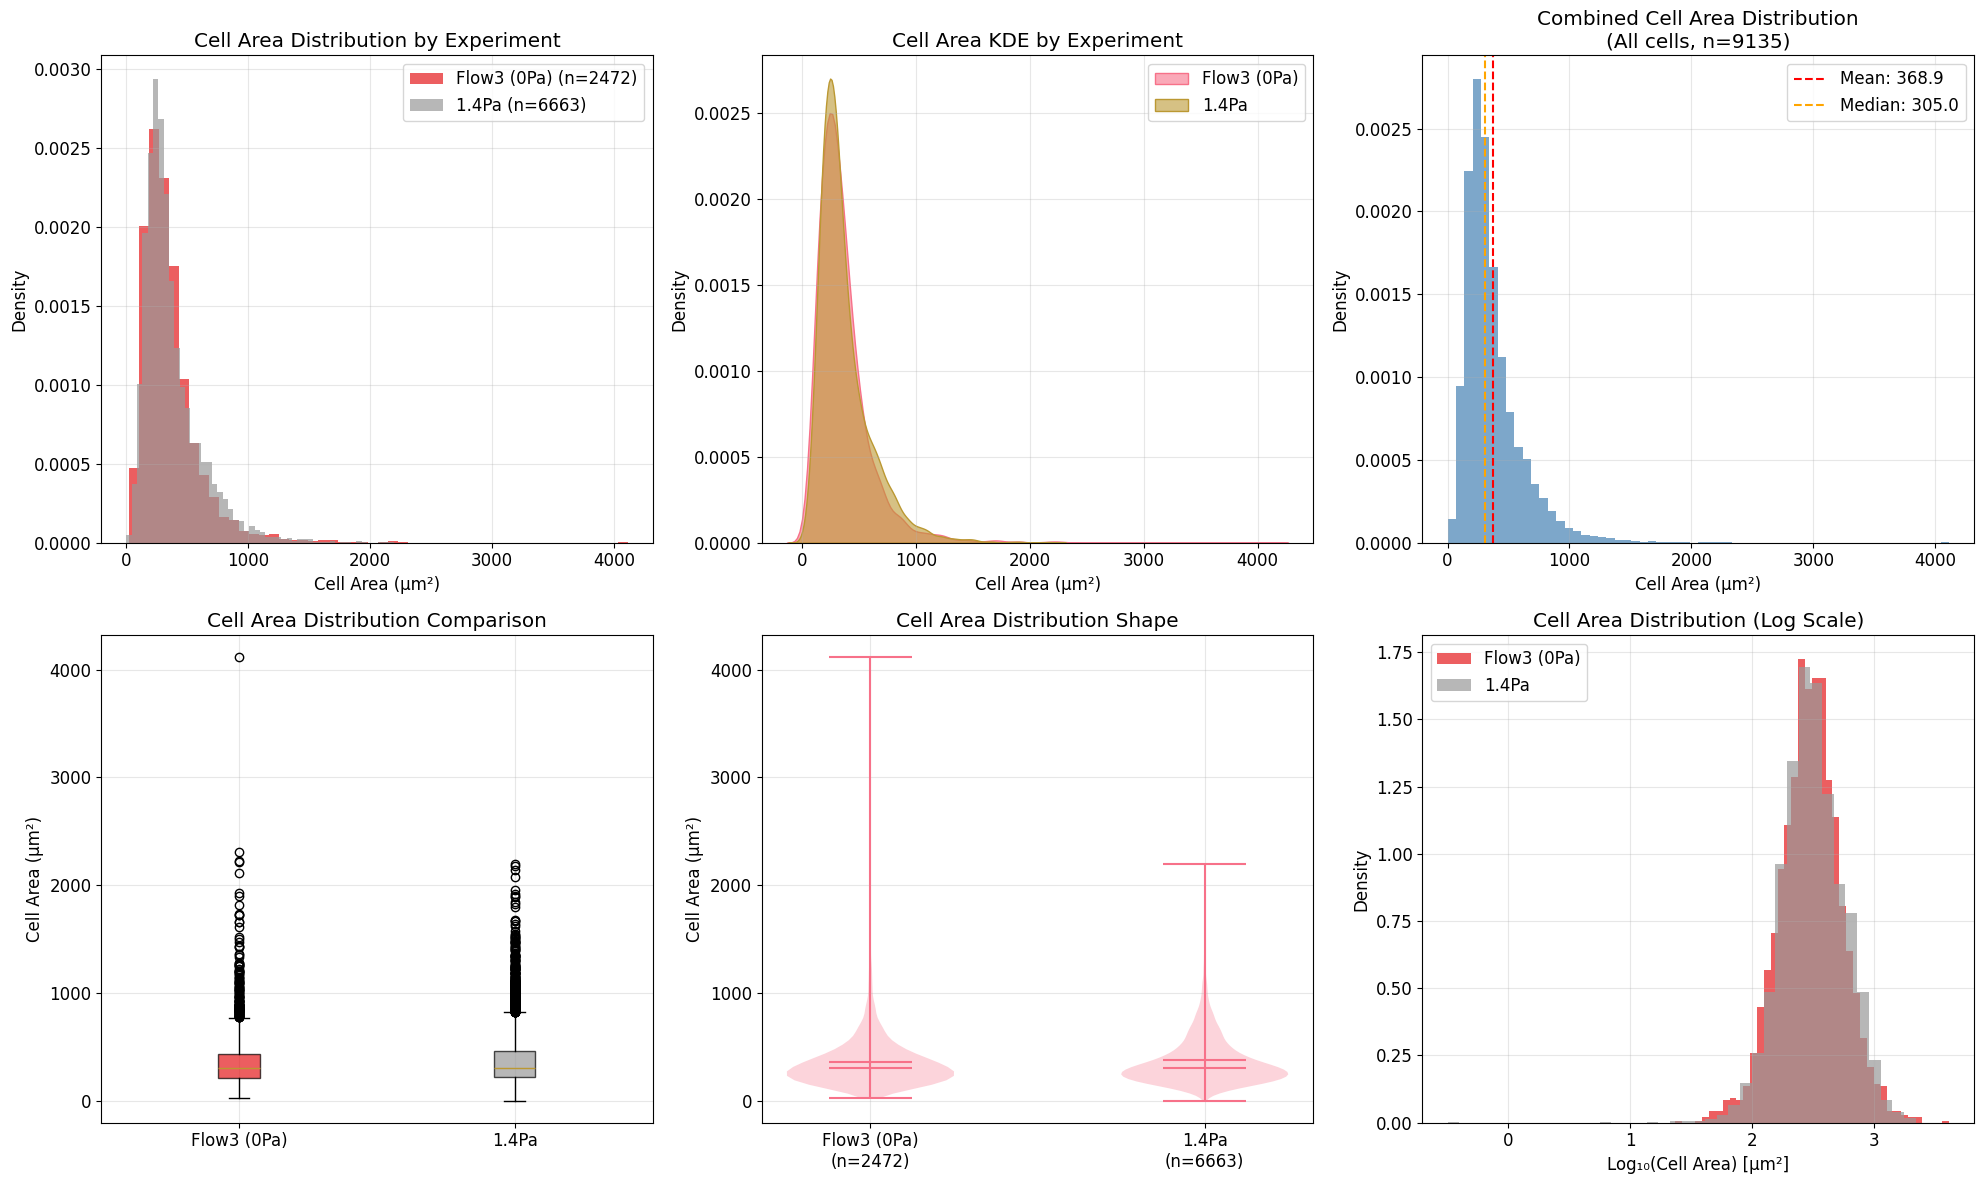

Cell area distribution plots saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/individual_cell_area_distributions.png


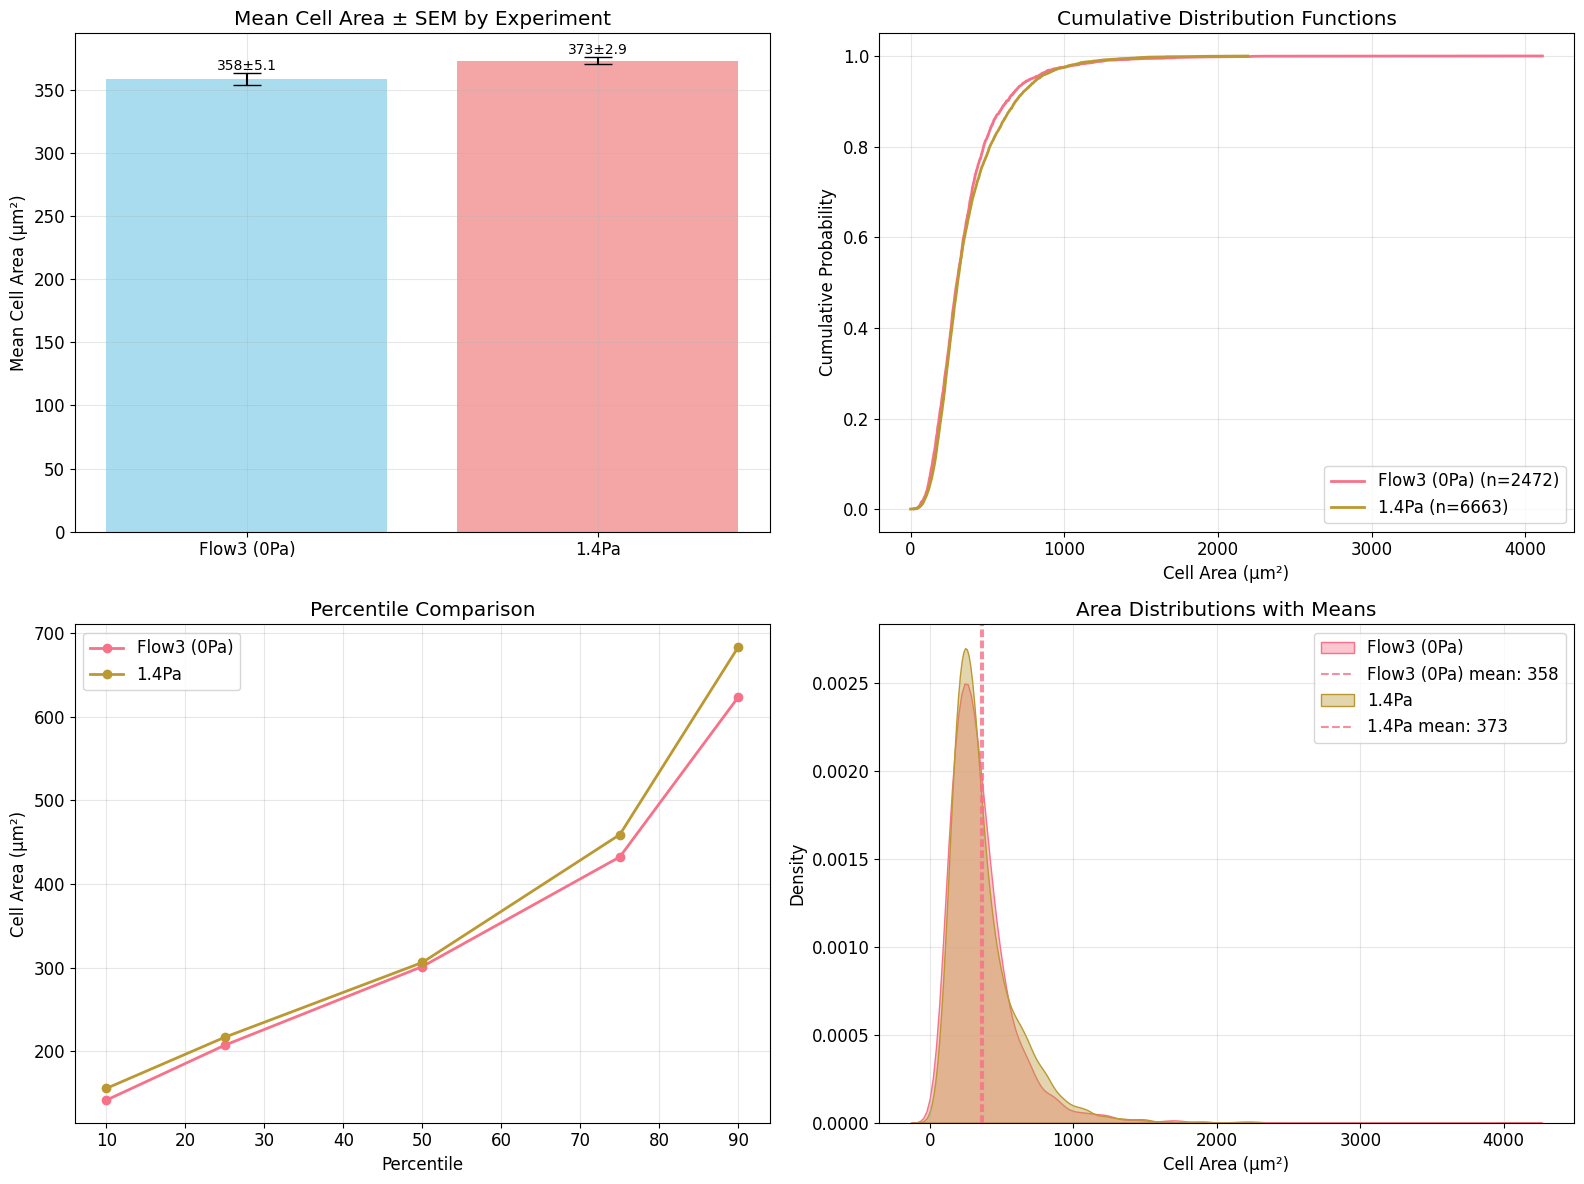

Statistical comparison plots saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/cell_area_statistical_comparison.png

COMPREHENSIVE CELL AREA STATISTICS

FLOW3 (0PA):
  Sample size: 2,472 cells
  Mean: 358.4 μm²
  Median: 301.3 μm²


IndexError: invalid index to scalar variable.

In [2]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skimage.measure import regionprops
from skimage.io import imread

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Define magnification-specific parameters
MAGNIFICATION_PARAMS = {
    'x20': {
        'pixel_size_um': 0.325,
        'theoretical_fov_mm2': 1.0,
    },
    'x40': {
        'pixel_size_um': 0.1625,
        'theoretical_fov_mm2': 0.25,
    }
}

def extract_cell_areas_from_segmentation(tif_path, pixel_size_um):
    """
    Extract individual cell areas from segmentation TIF file.
    Returns list of cell areas in μm².
    """
    try:
        # Try reading with PIL first
        img = Image.open(tif_path)
        img_array = np.array(img)
    except Exception as e:
        try:
            # Fallback to OpenCV
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None, None
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None, None

    if img_array is None:
        return None, None

    try:
        # Get image dimensions
        height, width = img_array.shape[:2]

        # Use regionprops to measure individual cell areas
        regions = regionprops(img_array)

        # Extract areas and convert from pixels to μm²
        cell_areas_pixels = [region.area for region in regions]
        cell_areas_um2 = [area * (pixel_size_um ** 2) for area in cell_areas_pixels]

        return cell_areas_um2, len(cell_areas_um2)

    except Exception as e:
        print(f"Error processing regions in {tif_path}: {e}")
        return None, None

def create_cell_area_distribution_plots(all_cell_data, base_path):
    """Create distribution plots for individual cell areas"""

    # Create comprehensive figure
    fig = plt.subplots(2, 3, figsize=(20, 12))
    fig = plt.gcf()

    # Prepare data for plotting
    experiments = list(all_cell_data.keys())
    colors = plt.cm.Set1(np.linspace(0, 1, len(experiments)))

    # Plot 1: Individual histograms for each experiment
    plt.subplot(2, 3, 1)
    for i, (exp, areas) in enumerate(all_cell_data.items()):
        plt.hist(areas, alpha=0.7, label=f'{exp} (n={len(areas)})',
                bins=50, density=True, color=colors[i])
    plt.xlabel('Cell Area (μm²)')
    plt.ylabel('Density')
    plt.title('Cell Area Distribution by Experiment')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Kernel Density Estimation
    plt.subplot(2, 3, 2)
    for exp, areas in all_cell_data.items():
        if len(areas) > 1:
            sns.kdeplot(data=areas, label=f'{exp}', fill=True, alpha=0.6)
    plt.xlabel('Cell Area (μm²)')
    plt.ylabel('Density')
    plt.title('Cell Area KDE by Experiment')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Combined distribution (all experiments together)
    plt.subplot(2, 3, 3)
    all_areas_combined = []
    for areas in all_cell_data.values():
        all_areas_combined.extend(areas)

    plt.hist(all_areas_combined, bins=60, alpha=0.7, color='steelblue', density=True)
    plt.xlabel('Cell Area (μm²)')
    plt.ylabel('Density')
    plt.title(f'Combined Cell Area Distribution\n(All cells, n={len(all_areas_combined)})')
    plt.grid(True, alpha=0.3)

    # Add statistics text
    mean_area = np.mean(all_areas_combined)
    std_area = np.std(all_areas_combined)
    median_area = np.median(all_areas_combined)
    plt.axvline(mean_area, color='red', linestyle='--', label=f'Mean: {mean_area:.1f}')
    plt.axvline(median_area, color='orange', linestyle='--', label=f'Median: {median_area:.1f}')
    plt.legend()

    # Plot 4: Box plots comparison
    plt.subplot(2, 3, 4)
    box_data = [areas for areas in all_cell_data.values()]
    box_labels = list(all_cell_data.keys())
    bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)

    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    plt.ylabel('Cell Area (μm²)')
    plt.title('Cell Area Distribution Comparison')
    plt.grid(True, alpha=0.3)

    # Plot 5: Violin plots
    plt.subplot(2, 3, 5)
    violin_data = list(all_cell_data.values())
    violin_labels = [f'{exp}\n(n={len(areas)})' for exp, areas in all_cell_data.items()]

    parts = plt.violinplot(violin_data, positions=range(1, len(violin_data) + 1),
                          showmeans=True, showmedians=True)
    plt.xticks(range(1, len(violin_labels) + 1), violin_labels)
    plt.ylabel('Cell Area (μm²)')
    plt.title('Cell Area Distribution Shape')
    plt.grid(True, alpha=0.3)

    # Plot 6: Log-scale distribution (useful for biological data)
    plt.subplot(2, 3, 6)
    for i, (exp, areas) in enumerate(all_cell_data.items()):
        log_areas = np.log10(areas)
        plt.hist(log_areas, alpha=0.7, label=f'{exp}', bins=40,
                density=True, color=colors[i])
    plt.xlabel('Log₁₀(Cell Area) [μm²]')
    plt.ylabel('Density')
    plt.title('Cell Area Distribution (Log Scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(base_path, "individual_cell_area_distributions.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_path

def create_statistical_comparison_plots(all_cell_data, base_path):
    """Create statistical comparison plots"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Mean ± SEM comparison
    exp_names = list(all_cell_data.keys())
    means = [np.mean(areas) for areas in all_cell_data.values()]
    sems = [stats.sem(areas) for areas in all_cell_data.values()]
    stds = [np.std(areas) for areas in all_cell_data.values()]

    ax1 = axes[0, 0]
    bars = ax1.bar(exp_names, means, yerr=sems, capsize=10,
                   alpha=0.7, color=['skyblue', 'lightcoral'])
    ax1.set_ylabel('Mean Cell Area (μm²)')
    ax1.set_title('Mean Cell Area ± SEM by Experiment')
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bar, mean_val, sem_val in zip(bars, means, sems):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + sem_val,
                f'{mean_val:.0f}±{sem_val:.1f}', ha='center', va='bottom', fontsize=10)

    # Plot 2: Cumulative distribution functions
    ax2 = axes[0, 1]
    for exp, areas in all_cell_data.items():
        sorted_areas = np.sort(areas)
        cumulative = np.arange(1, len(sorted_areas) + 1) / len(sorted_areas)
        ax2.plot(sorted_areas, cumulative, linewidth=2,
                label=f'{exp} (n={len(areas)})')

    ax2.set_xlabel('Cell Area (μm²)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Functions')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Percentile comparison
    ax3 = axes[1, 0]
    percentiles = [10, 25, 50, 75, 90]

    for exp, areas in all_cell_data.items():
        perc_values = [np.percentile(areas, p) for p in percentiles]
        ax3.plot(percentiles, perc_values, 'o-', linewidth=2,
                label=f'{exp}', markersize=6)

    ax3.set_xlabel('Percentile')
    ax3.set_ylabel('Cell Area (μm²)')
    ax3.set_title('Percentile Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Density overlay with statistics
    ax4 = axes[1, 1]
    for exp, areas in all_cell_data.items():
        mean_val = np.mean(areas)
        std_val = np.std(areas)

        # Plot KDE
        if len(areas) > 1:
            sns.kdeplot(data=areas, ax=ax4, label=f'{exp}', fill=True, alpha=0.4)

        # Add mean line
        ax4.axvline(mean_val, linestyle='--', alpha=0.8,
                   label=f'{exp} mean: {mean_val:.0f}')

    ax4.set_xlabel('Cell Area (μm²)')
    ax4.set_ylabel('Density')
    ax4.set_title('Area Distributions with Means')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    stat_plot_path = os.path.join(base_path, "cell_area_statistical_comparison.png")
    plt.savefig(stat_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return stat_plot_path

# Main analysis code
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
folders = ["flow3-x20", "1.4Pa-x40", "1.4Pa-x20"]
subfolder_name = "Cell_merged_conservative"

print("Starting individual cell area analysis...")
print("="*60)

# Dictionary to store all cell areas by experiment
all_cell_areas = {}

# Process each folder
for folder in folders:
    folder_path = os.path.join(base_path, folder, subfolder_name)
    print(f"\nProcessing folder: {folder}")

    if not os.path.exists(folder_path):
        print(f"Warning: Path '{folder_path}' not found. Skipping.")
        continue

    tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

    if not tif_files:
        print(f"No TIF files found in {folder_path}")
        continue

    print(f"Found {len(tif_files)} TIF file(s)")

    # Extract experiment parameters
    if "flow3" in folder:
        experiment = 'Flow3 (0Pa)'
    elif "1.4Pa" in folder:
        experiment = '1.4Pa'
    else:
        experiment = 'Unknown'

    if "x40" in folder:
        magnification = 'x40'
    elif "x20" in folder:
        magnification = 'x20'
    else:
        magnification = 'unknown'

    # Get pixel size for area conversion
    mag_params = MAGNIFICATION_PARAMS.get(magnification, {})
    pixel_size_um = mag_params.get('pixel_size_um', 1.0)

    # Store all cell areas for this experiment
    experiment_cell_areas = []

    # Process each TIF file
    for tif_file in tif_files:
        file_name = os.path.basename(tif_file)
        print(f"  Processing: {file_name}")

        cell_areas, cell_count = extract_cell_areas_from_segmentation(tif_file, pixel_size_um)

        if cell_areas is not None:
            experiment_cell_areas.extend(cell_areas)
            print(f"    Found {cell_count} cells")
        else:
            print(f"    Failed to process {file_name}")

    # Store results for this experiment
    if experiment_cell_areas:
        all_cell_areas[experiment] = experiment_cell_areas
        print(f"\nExperiment {experiment} summary:")
        print(f"  Total cells analyzed: {len(experiment_cell_areas)}")
        print(f"  Mean area: {np.mean(experiment_cell_areas):.1f} μm²")
        print(f"  Median area: {np.median(experiment_cell_areas):.1f} μm²")
        print(f"  Std dev: {np.std(experiment_cell_areas):.1f} μm²")

# Create distribution plots if we have data
if all_cell_areas:
    print("\n" + "="*80)
    print("CREATING CELL AREA DISTRIBUTION PLOTS")
    print("="*80)

    # Create distribution plots
    plot1_path = create_cell_area_distribution_plots(all_cell_areas, base_path)
    print(f"Cell area distribution plots saved: {plot1_path}")

    # Create statistical comparison plots
    plot2_path = create_statistical_comparison_plots(all_cell_areas, base_path)
    print(f"Statistical comparison plots saved: {plot2_path}")

    # Print comprehensive statistics
    print("\n" + "="*60)
    print("COMPREHENSIVE CELL AREA STATISTICS")
    print("="*60)

    for exp, areas in all_cell_areas.items():
        print(f"\n{exp.upper()}:")
        print(f"  Sample size: {len(areas):,} cells")
        print(f"  Mean: {np.mean(areas):.1f} μm²")
        print(f"  Median: {np.median(areas):.1f} μm²")
        print(f"  Mode (approx): {stats.mode(np.round(areas))[0][0]:.1f} μm²")
        print(f"  Std Dev: {np.std(areas):.1f} μm²")
        print(f"  Coefficient of Variation: {(np.std(areas)/np.mean(areas)*100):.1f}%")
        print(f"  Min: {np.min(areas):.1f} μm²")
        print(f"  Max: {np.max(areas):.1f} μm²")
        print(f"  25th percentile: {np.percentile(areas, 25):.1f} μm²")
        print(f"  75th percentile: {np.percentile(areas, 75):.1f} μm²")
        print(f"  Interquartile Range: {np.percentile(areas, 75) - np.percentile(areas, 25):.1f} μm²")

        # Test for normality (use subset if too many data points)
        test_data = areas if len(areas) <= 5000 else np.random.choice(areas, 5000, replace=False)
        shapiro_stat, shapiro_p = stats.shapiro(test_data)
        print(f"  Normality test (Shapiro-Wilk): p = {shapiro_p:.4f}")
        if shapiro_p > 0.05:
            print(f"    → Data appears normally distributed (p > 0.05)")
        else:
            print(f"    → Data is not normally distributed (p ≤ 0.05)")

    # Statistical comparison between experiments
    if len(all_cell_areas) >= 2:
        print(f"\n" + "="*50)
        print("STATISTICAL COMPARISON BETWEEN EXPERIMENTS")
        print("="*50)

        exp_list = list(all_cell_areas.keys())
        areas_list = list(all_cell_areas.values())

        if len(exp_list) == 2:
            # T-test
            t_stat, t_p = stats.ttest_ind(areas_list[0], areas_list[1])
            print(f"T-test p-value: {t_p:.6f}")

            # Mann-Whitney U test (non-parametric)
            u_stat, u_p = stats.mannwhitneyu(areas_list[0], areas_list[1], alternative='two-sided')
            print(f"Mann-Whitney U test p-value: {u_p:.6f}")

            # Effect size (Cohen's d)
            pooled_std = np.sqrt(((len(areas_list[0]) - 1) * np.var(areas_list[0], ddof=1) +
                                (len(areas_list[1]) - 1) * np.var(areas_list[1], ddof=1)) /
                               (len(areas_list[0]) + len(areas_list[1]) - 2))
            cohens_d = (np.mean(areas_list[0]) - np.mean(areas_list[1])) / pooled_std
            print(f"Effect size (Cohen's d): {cohens_d:.3f}")

            # Practical interpretation
            mean_diff = np.mean(areas_list[0]) - np.mean(areas_list[1])
            percent_diff = (mean_diff / np.mean(areas_list[1])) * 100
            print(f"Mean difference: {mean_diff:.1f} μm² ({percent_diff:+.1f}%)")

    print(f"\n" + "="*80)
    print("CELL AREA ANALYSIS COMPLETE")
    print("="*80)
    print("Distribution plots created:")
    print(f"1. {plot1_path}")
    print(f"2. {plot2_path}")

else:
    print("No cell area data found. Please check your segmentation files.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting individual cell area analysis by condition...

Processing folder: flow3-x20
Found 8 TIF file(s)
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
    Found 329 cells
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
    Found 368 cells
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif
    Found 385 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq001_cell_mask_merged_conservative.tif
    Found 264 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq002_cell_mask_merged_conservative.tif
    Found 210 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq003_cell_mask_merged_conservative.tif
    Found 294 cells
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq004_cell_mask_merged_conservative.tif
    Found 287 cells
  Proc

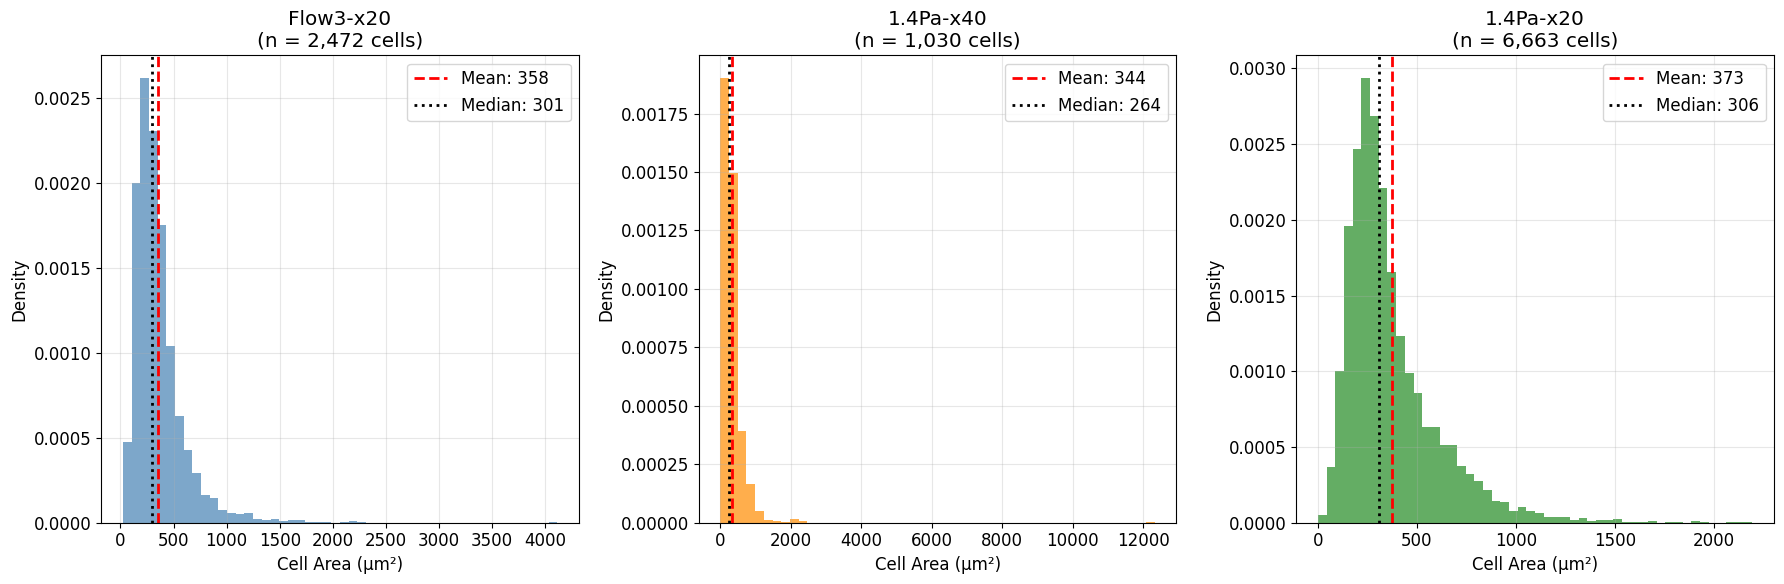

Individual density plots saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/simple_cell_area_densities.png


/tmp/ipython-input-3-3955511577.py:136: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)


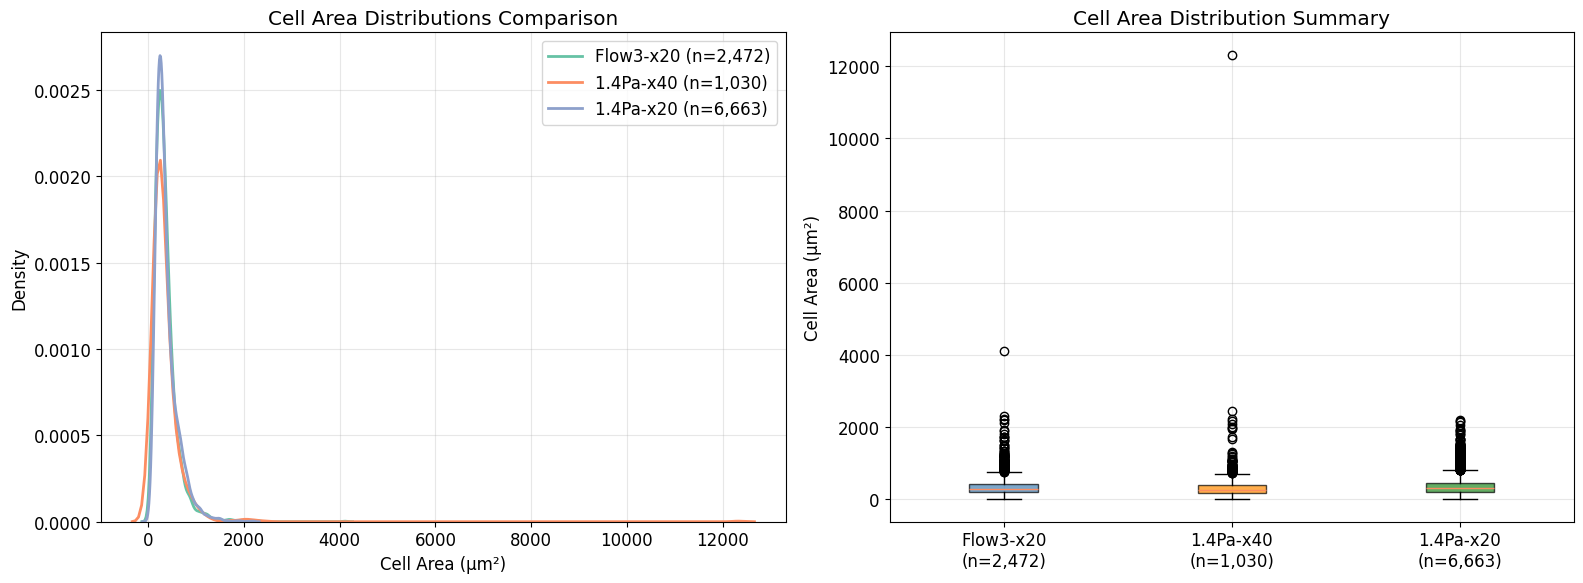

Comparison plots saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/cell_area_comparison.png

CELL AREA STATISTICS BY CONDITION

FLOW3-X20:
  Sample size: 2,472 cells
  Mean: 358.4 μm²
  Median: 301.3 μm²
  Std Dev: 251.2 μm²
  Min: 23.1 μm²
  Max: 4111.6 μm²
  25th percentile: 207.4 μm²
  75th percentile: 432.4 μm²
  Normality test p-value: 0.0000
    → Not normally distributed

1.4PA-X40:
  Sample size: 1,030 cells
  Mean: 343.8 μm²
  Median: 264.4 μm²
  Std Dev: 458.1 μm²
  Min: 8.1 μm²
  Max: 12323.7 μm²
  25th percentile: 178.2 μm²
  75th percentile: 393.1 μm²
  Normality test p-value: 0.0000
    → Not normally distributed

1.4PA-X20:
  Sample size: 6,663 cells
  Mean: 372.8 μm²
  Median: 306.2 μm²
  Std Dev: 238.4 μm²
  Min: 0.3 μm²
  Max: 2193.9 μm²
  25th percentile: 216.9 μm²
  75th percentile: 459.0 μm²
  Normality test p-value: 0.0000
    → Not normally distributed

PAIRWISE STATISTICAL COMPARISONS

Flow3-x20 vs 1.4Pa-x40:
  Mean difference: 14.6 μm² 

In [3]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skimage.measure import regionprops

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

# Define magnification-specific parameters
MAGNIFICATION_PARAMS = {
    'x20': {
        'pixel_size_um': 0.325,
    },
    'x40': {
        'pixel_size_um': 0.1625,
    }
}

def extract_cell_areas_from_segmentation(tif_path, pixel_size_um):
    """
    Extract individual cell areas from segmentation TIF file.
    Returns list of cell areas in μm².
    """
    try:
        # Try reading with PIL first
        img = Image.open(tif_path)
        img_array = np.array(img)
    except Exception as e:
        try:
            # Fallback to OpenCV
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None

    if img_array is None:
        return None

    try:
        # Use regionprops to measure individual cell areas
        regions = regionprops(img_array)

        # Extract areas and convert from pixels to μm²
        cell_areas_pixels = [region.area for region in regions]
        cell_areas_um2 = [area * (pixel_size_um ** 2) for area in cell_areas_pixels]

        return cell_areas_um2

    except Exception as e:
        print(f"Error processing regions in {tif_path}: {e}")
        return None

def create_simple_density_plots(all_cell_data, base_path):
    """Create simple, clean density plots"""

    # Create figure with separate subplots for each condition
    n_conditions = len(all_cell_data)
    fig, axes = plt.subplots(1, n_conditions, figsize=(6*n_conditions, 6))

    # If only one condition, make axes a list
    if n_conditions == 1:
        axes = [axes]

    colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson']

    # Create individual density plot for each condition
    for i, (condition, areas) in enumerate(all_cell_data.items()):
        ax = axes[i]

        # Create density plot
        ax.hist(areas, bins=50, density=True, alpha=0.7, color=colors[i % len(colors)])

        # Add mean and median lines
        mean_val = np.mean(areas)
        median_val = np.median(areas)
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.0f}')
        ax.axvline(median_val, color='black', linestyle=':', linewidth=2, label=f'Median: {median_val:.0f}')

        # Formatting
        ax.set_xlabel('Cell Area (μm²)')
        ax.set_ylabel('Density')
        ax.set_title(f'{condition}\n(n = {len(areas):,} cells)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(base_path, "simple_cell_area_densities.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_path

def create_comparison_plot(all_cell_data, base_path):
    """Create a simple comparison plot"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Overlapping density curves (KDE)
    for condition, areas in all_cell_data.items():
        if len(areas) > 1:
            sns.kdeplot(data=areas, ax=ax1, label=f'{condition} (n={len(areas):,})',
                       fill=False, linewidth=2)

    ax1.set_xlabel('Cell Area (μm²)')
    ax1.set_ylabel('Density')
    ax1.set_title('Cell Area Distributions Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot comparison
    box_data = [areas for areas in all_cell_data.values()]
    box_labels = [f'{cond}\n(n={len(areas):,})' for cond, areas in all_cell_data.items()]

    bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)

    # Color the boxes
    colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_ylabel('Cell Area (μm²)')
    ax2.set_title('Cell Area Distribution Summary')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    comparison_path = os.path.join(base_path, "cell_area_comparison.png")
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    plt.show()

    return comparison_path

# Main analysis code
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
folders = ["flow3-x20", "1.4Pa-x40", "1.4Pa-x20"]
subfolder_name = "Cell_merged_conservative"

print("Starting individual cell area analysis by condition...")
print("="*60)

# Dictionary to store all cell areas by condition (experiment + magnification)
all_cell_areas = {}

# Process each folder separately
for folder in folders:
    folder_path = os.path.join(base_path, folder, subfolder_name)
    print(f"\nProcessing folder: {folder}")

    if not os.path.exists(folder_path):
        print(f"Warning: Path '{folder_path}' not found. Skipping.")
        continue

    tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

    if not tif_files:
        print(f"No TIF files found in {folder_path}")
        continue

    print(f"Found {len(tif_files)} TIF file(s)")

    # Create condition name
    if "flow3" in folder and "x20" in folder:
        condition = "Flow3-x20"
    elif "1.4Pa" in folder and "x40" in folder:
        condition = "1.4Pa-x40"
    elif "1.4Pa" in folder and "x20" in folder:
        condition = "1.4Pa-x20"
    else:
        condition = folder

    # Get magnification info
    if "x40" in folder:
        magnification = 'x40'
    elif "x20" in folder:
        magnification = 'x20'
    else:
        magnification = 'unknown'

    # Get pixel size for area conversion
    mag_params = MAGNIFICATION_PARAMS.get(magnification, {})
    pixel_size_um = mag_params.get('pixel_size_um', 1.0)

    # Store all cell areas for this condition
    condition_cell_areas = []

    # Process each TIF file
    for tif_file in tif_files:
        file_name = os.path.basename(tif_file)
        print(f"  Processing: {file_name}")

        cell_areas = extract_cell_areas_from_segmentation(tif_file, pixel_size_um)

        if cell_areas is not None:
            condition_cell_areas.extend(cell_areas)
            print(f"    Found {len(cell_areas)} cells")
        else:
            print(f"    Failed to process {file_name}")

    # Store results for this condition
    if condition_cell_areas:
        all_cell_areas[condition] = condition_cell_areas
        print(f"\nCondition {condition} summary:")
        print(f"  Total cells analyzed: {len(condition_cell_areas):,}")
        print(f"  Mean area: {np.mean(condition_cell_areas):.1f} μm²")
        print(f"  Median area: {np.median(condition_cell_areas):.1f} μm²")

# Create plots if we have data
if all_cell_areas:
    print("\n" + "="*80)
    print("CREATING SIMPLE CELL AREA DISTRIBUTION PLOTS")
    print("="*80)

    # Create simple density plots
    plot1_path = create_simple_density_plots(all_cell_areas, base_path)
    print(f"Individual density plots saved: {plot1_path}")

    # Create comparison plot
    plot2_path = create_comparison_plot(all_cell_areas, base_path)
    print(f"Comparison plots saved: {plot2_path}")

    # Print comprehensive statistics
    print("\n" + "="*60)
    print("CELL AREA STATISTICS BY CONDITION")
    print("="*60)

    for condition, areas in all_cell_areas.items():
        print(f"\n{condition.upper()}:")
        print(f"  Sample size: {len(areas):,} cells")
        print(f"  Mean: {np.mean(areas):.1f} μm²")
        print(f"  Median: {np.median(areas):.1f} μm²")
        print(f"  Std Dev: {np.std(areas):.1f} μm²")
        print(f"  Min: {np.min(areas):.1f} μm²")
        print(f"  Max: {np.max(areas):.1f} μm²")
        print(f"  25th percentile: {np.percentile(areas, 25):.1f} μm²")
        print(f"  75th percentile: {np.percentile(areas, 75):.1f} μm²")

        # Fixed normality test
        if len(areas) > 3:
            # Use subset if too many data points for Shapiro-Wilk test
            test_data = areas if len(areas) <= 5000 else np.random.choice(areas, 5000, replace=False)
            try:
                shapiro_stat, shapiro_p = stats.shapiro(test_data)
                print(f"  Normality test p-value: {shapiro_p:.4f}")
                if shapiro_p > 0.05:
                    print(f"    → Appears normally distributed")
                else:
                    print(f"    → Not normally distributed")
            except:
                print(f"    → Could not perform normality test")

    # Statistical comparisons between conditions
    if len(all_cell_areas) >= 2:
        print(f"\n" + "="*50)
        print("PAIRWISE STATISTICAL COMPARISONS")
        print("="*50)

        conditions = list(all_cell_areas.keys())

        for i in range(len(conditions)):
            for j in range(i+1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                areas1, areas2 = all_cell_areas[cond1], all_cell_areas[cond2]

                print(f"\n{cond1} vs {cond2}:")

                # Basic comparison
                mean_diff = np.mean(areas1) - np.mean(areas2)
                percent_diff = (mean_diff / np.mean(areas2)) * 100
                print(f"  Mean difference: {mean_diff:.1f} μm² ({percent_diff:+.1f}%)")

                # Statistical tests
                try:
                    # Mann-Whitney U test (non-parametric, good for large samples)
                    u_stat, u_p = stats.mannwhitneyu(areas1, areas2, alternative='two-sided')
                    print(f"  Mann-Whitney U test p-value: {u_p:.6f}")

                    if u_p < 0.001:
                        print(f"    → Highly significant difference (p < 0.001)")
                    elif u_p < 0.01:
                        print(f"    → Very significant difference (p < 0.01)")
                    elif u_p < 0.05:
                        print(f"    → Significant difference (p < 0.05)")
                    else:
                        print(f"    → No significant difference (p ≥ 0.05)")
                except:
                    print(f"    → Could not perform statistical test")

    print(f"\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("Simple plots created:")
    print(f"1. Individual density plots: {plot1_path}")
    print(f"2. Comparison plots: {plot2_path}")

else:
    print("No cell area data found. Please check your segmentation files.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting cell area analysis in PIXELS for Static-x20 only...

Processing Static-x20 folder: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/flow3-x20/Cell_merged_conservative
Found 8 TIF file(s)
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
    Found 329 cells
    Mean area in this image: 3187.2 pixels²
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
    Found 368 cells
    Mean area in this image: 2849.4 pixels²
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif
    Found 385 cells
    Mean area in this image: 2723.6 pixels²
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq001_cell_mask_merged_conservative.tif
    Found 264 cells
    Mean area in this image: 3971.9 pixels²
  Processing: 1.4Pa_U_05mar19_20

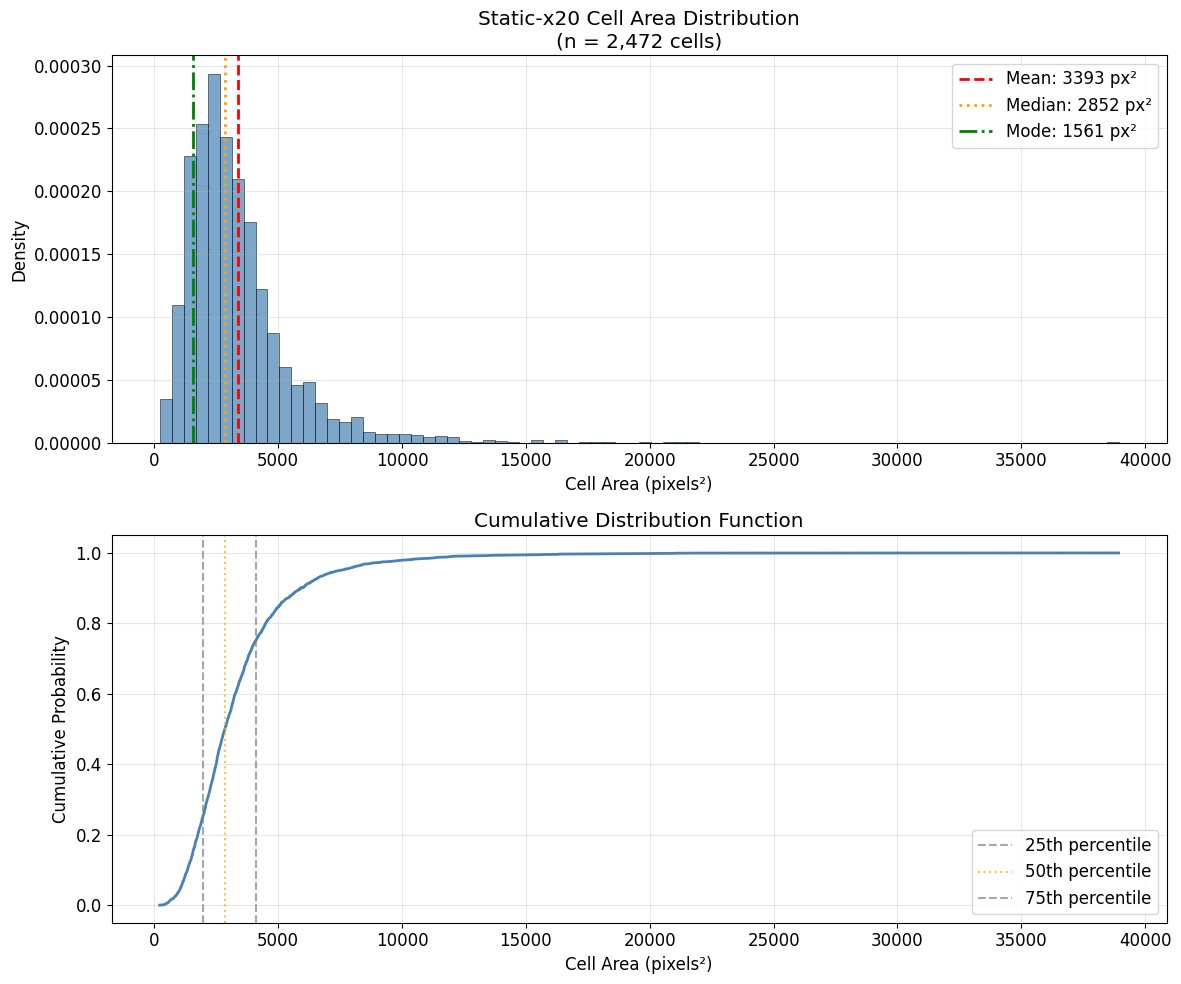

Main distribution plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/static_x20_cell_area_distribution.png


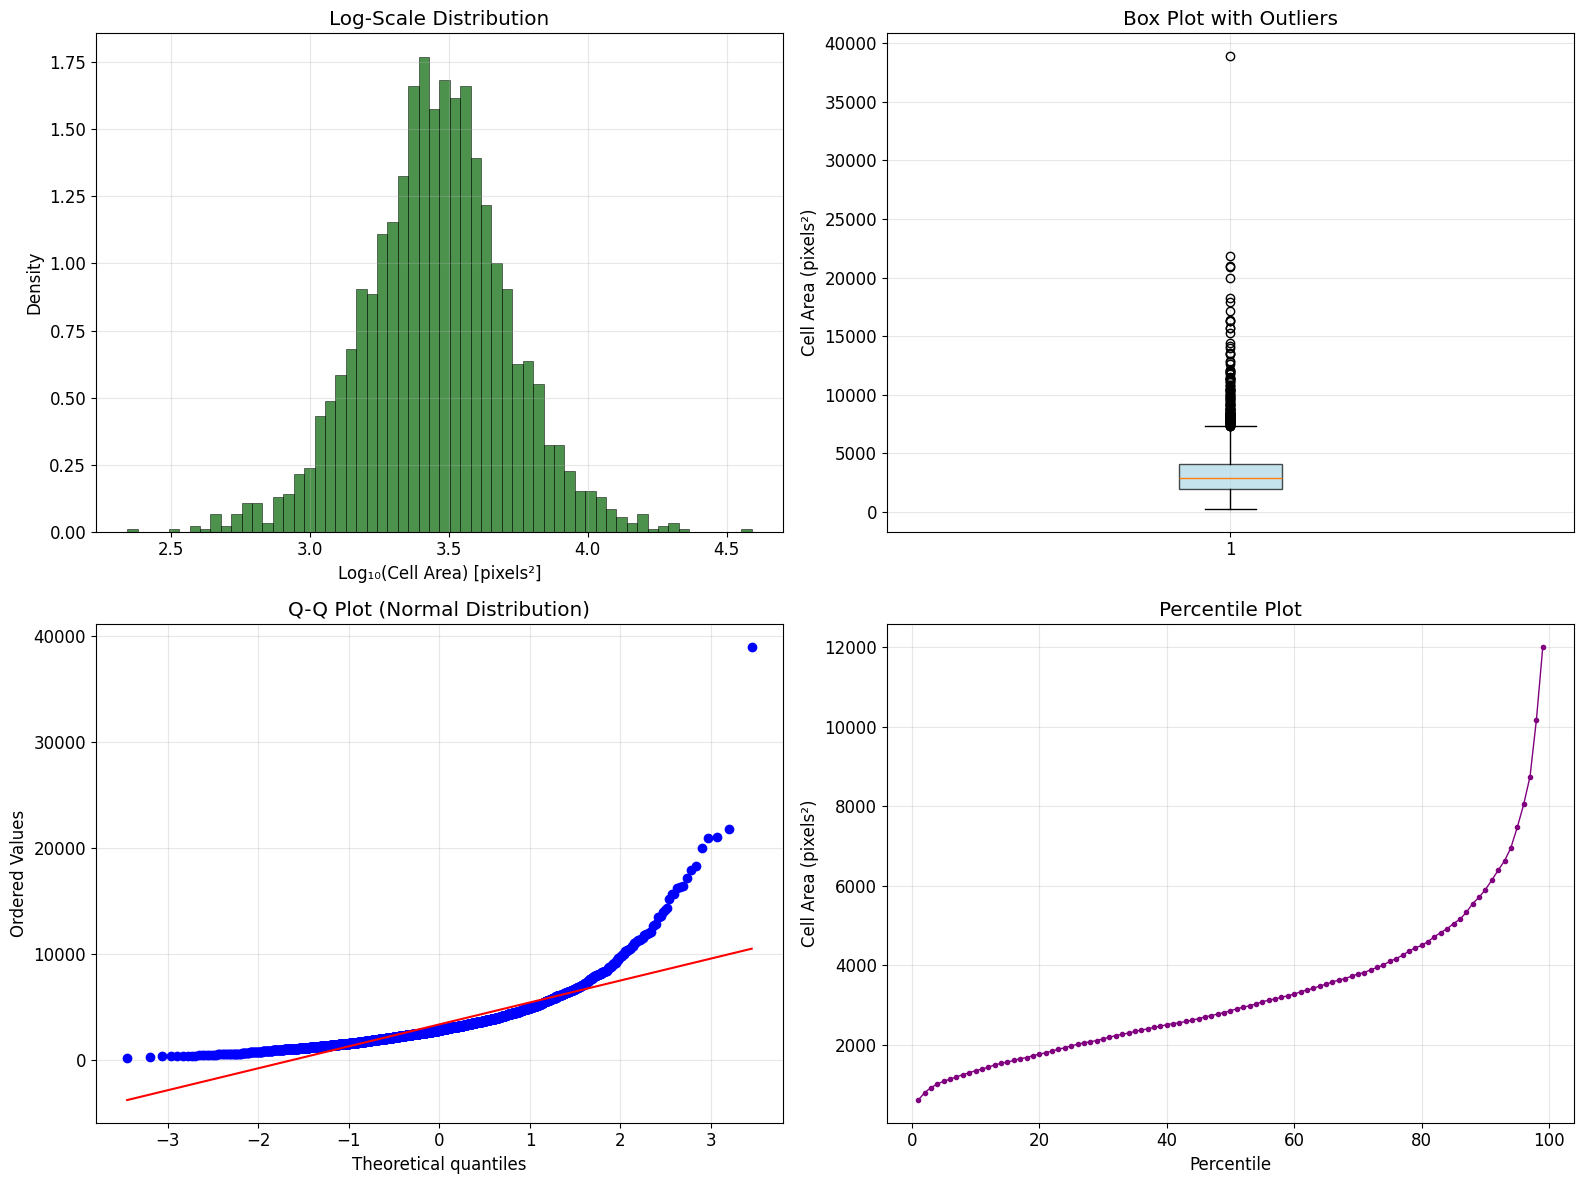

Detailed analysis plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/static_x20_detailed_analysis.png

STATIC-X20 CELL AREA STATISTICS (PIXELS)

STATIC-X20 ANALYSIS:
  Sample size: 2,472 cells
  Total images processed: 8
  Average cells per image: 309.0

CENTRAL TENDENCIES:
  Mean: 3393.4 pixels²
  Median: 2852.5 pixels²
  Mode (most frequent): 1561 pixels²

VARIABILITY:
  Standard Deviation: 2378.3 pixels²
  Coefficient of Variation: 70.1%
  Variance: 5656453.6 pixels⁴
  Range: 38707 pixels²
  Interquartile Range: 2130.2 pixels²

EXTREMES:
  Minimum: 219 pixels²
  Maximum: 38926 pixels²
  1st percentile: 601.7 pixels²
  99th percentile: 12012.1 pixels²

QUARTILES:
  25th percentile (Q1): 1963.2 pixels²
  50th percentile (Q2/Median): 2852.5 pixels²
  75th percentile (Q3): 4093.5 pixels²

DISTRIBUTION SHAPE:
  Skewness: 3.592
    → Right-skewed (tail extends to larger values)
  Kurtosis: 29.081
    → Heavy-tailed (more outliers than normal distribution)

NOR

In [4]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skimage.measure import regionprops

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def extract_cell_areas_pixels(tif_path):
    """
    Extract individual cell areas from segmentation TIF file.
    Returns list of cell areas in PIXELS.
    """
    try:
        # Try reading with PIL first
        img = Image.open(tif_path)
        img_array = np.array(img)
    except Exception as e:
        try:
            # Fallback to OpenCV
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None

    if img_array is None:
        return None

    try:
        # Use regionprops to measure individual cell areas
        regions = regionprops(img_array)

        # Extract areas in pixels (no conversion)
        cell_areas_pixels = [region.area for region in regions]

        return cell_areas_pixels

    except Exception as e:
        print(f"Error processing regions in {tif_path}: {e}")
        return None

def create_static_x20_distribution_plot(cell_areas, base_path):
    """Create distribution plot for Static-x20 cell areas in pixels"""

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Main histogram
    ax1.hist(cell_areas, bins=80, density=True, alpha=0.7, color='steelblue',
             edgecolor='black', linewidth=0.5)

    # Add statistics lines
    mean_val = np.mean(cell_areas)
    median_val = np.median(cell_areas)
    mode_val = stats.mode(cell_areas, keepdims=True)[0][0]

    ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.0f} px²')
    ax1.axvline(median_val, color='orange', linestyle=':', linewidth=2,
                label=f'Median: {median_val:.0f} px²')
    ax1.axvline(mode_val, color='green', linestyle='-.', linewidth=2,
                label=f'Mode: {mode_val:.0f} px²')

    # Formatting
    ax1.set_xlabel('Cell Area (pixels²)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'Static-x20 Cell Area Distribution\n(n = {len(cell_areas):,} cells)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_areas = np.sort(cell_areas)
    cumulative = np.arange(1, len(sorted_areas) + 1) / len(sorted_areas)
    ax2.plot(sorted_areas, cumulative, linewidth=2, color='steelblue')

    # Add percentile lines
    p25 = np.percentile(cell_areas, 25)
    p50 = np.percentile(cell_areas, 50)
    p75 = np.percentile(cell_areas, 75)

    ax2.axvline(p25, color='gray', linestyle='--', alpha=0.7, label='25th percentile')
    ax2.axvline(p50, color='orange', linestyle=':', alpha=0.7, label='50th percentile')
    ax2.axvline(p75, color='gray', linestyle='--', alpha=0.7, label='75th percentile')

    ax2.set_xlabel('Cell Area (pixels²)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Function')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(base_path, "static_x20_cell_area_distribution.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_path

def create_detailed_analysis_plot(cell_areas, base_path):
    """Create detailed analysis plots"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Log-scale histogram
    log_areas = np.log10(cell_areas)
    ax1.hist(log_areas, bins=60, density=True, alpha=0.7, color='darkgreen',
             edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Log₁₀(Cell Area) [pixels²]')
    ax1.set_ylabel('Density')
    ax1.set_title('Log-Scale Distribution')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot with outliers
    bp = ax2.boxplot(cell_areas, patch_artist=True, showfliers=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax2.set_ylabel('Cell Area (pixels²)')
    ax2.set_title('Box Plot with Outliers')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Q-Q plot for normality check
    stats.probplot(cell_areas, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normal Distribution)')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Percentile plot
    percentiles = np.arange(1, 100, 1)
    perc_values = [np.percentile(cell_areas, p) for p in percentiles]
    ax4.plot(percentiles, perc_values, 'o-', linewidth=1, markersize=3, color='purple')
    ax4.set_xlabel('Percentile')
    ax4.set_ylabel('Cell Area (pixels²)')
    ax4.set_title('Percentile Plot')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    analysis_path = os.path.join(base_path, "static_x20_detailed_analysis.png")
    plt.savefig(analysis_path, dpi=300, bbox_inches='tight')
    plt.show()

    return analysis_path

# Main analysis code - FOCUS ON Static-x20 ONLY
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
static_folder = "flow3-x20"  # This is the Static-x20 folder
subfolder_name = "Cell_merged_conservative"

print("Starting cell area analysis in PIXELS for Static-x20 only...")
print("="*60)

folder_path = os.path.join(base_path, static_folder, subfolder_name)
print(f"\nProcessing Static-x20 folder: {folder_path}")

if not os.path.exists(folder_path):
    print(f"Error: Path '{folder_path}' not found.")
    print("Please check that the folder exists.")
    exit()

tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

if not tif_files:
    print(f"No TIF files found in {folder_path}")
    exit()

print(f"Found {len(tif_files)} TIF file(s)")

# Store all cell areas for Static-x20 (in pixels)
static_cell_areas = []

# Process each TIF file
for tif_file in tif_files:
    file_name = os.path.basename(tif_file)
    print(f"  Processing: {file_name}")

    cell_areas_pixels = extract_cell_areas_pixels(tif_file)

    if cell_areas_pixels is not None:
        static_cell_areas.extend(cell_areas_pixels)
        print(f"    Found {len(cell_areas_pixels)} cells")
        print(f"    Mean area in this image: {np.mean(cell_areas_pixels):.1f} pixels²")
    else:
        print(f"    Failed to process {file_name}")

# Analyze results if we have data
if static_cell_areas:
    print("\n" + "="*80)
    print("CREATING STATIC-X20 CELL AREA DISTRIBUTION PLOTS")
    print("="*80)

    # Create main distribution plot
    plot1_path = create_static_x20_distribution_plot(static_cell_areas, base_path)
    print(f"Main distribution plot saved: {plot1_path}")

    # Create detailed analysis plot
    plot2_path = create_detailed_analysis_plot(static_cell_areas, base_path)
    print(f"Detailed analysis plot saved: {plot2_path}")

    # Print comprehensive statistics
    print("\n" + "="*60)
    print("STATIC-X20 CELL AREA STATISTICS (PIXELS)")
    print("="*60)

    areas = static_cell_areas
    print(f"\nSTATIC-X20 ANALYSIS:")
    print(f"  Sample size: {len(areas):,} cells")
    print(f"  Total images processed: {len(tif_files)}")
    print(f"  Average cells per image: {len(areas)/len(tif_files):.1f}")

    print(f"\nCENTRAL TENDENCIES:")
    print(f"  Mean: {np.mean(areas):.1f} pixels²")
    print(f"  Median: {np.median(areas):.1f} pixels²")
    print(f"  Mode (most frequent): {stats.mode(areas, keepdims=True)[0][0]:.0f} pixels²")

    print(f"\nVARIABILITY:")
    print(f"  Standard Deviation: {np.std(areas):.1f} pixels²")
    print(f"  Coefficient of Variation: {(np.std(areas)/np.mean(areas)*100):.1f}%")
    print(f"  Variance: {np.var(areas):.1f} pixels⁴")
    print(f"  Range: {np.max(areas) - np.min(areas):.0f} pixels²")
    print(f"  Interquartile Range: {np.percentile(areas, 75) - np.percentile(areas, 25):.1f} pixels²")

    print(f"\nEXTREMES:")
    print(f"  Minimum: {np.min(areas):.0f} pixels²")
    print(f"  Maximum: {np.max(areas):.0f} pixels²")
    print(f"  1st percentile: {np.percentile(areas, 1):.1f} pixels²")
    print(f"  99th percentile: {np.percentile(areas, 99):.1f} pixels²")

    print(f"\nQUARTILES:")
    print(f"  25th percentile (Q1): {np.percentile(areas, 25):.1f} pixels²")
    print(f"  50th percentile (Q2/Median): {np.percentile(areas, 50):.1f} pixels²")
    print(f"  75th percentile (Q3): {np.percentile(areas, 75):.1f} pixels²")

    print(f"\nDISTRIBUTION SHAPE:")
    print(f"  Skewness: {stats.skew(areas):.3f}")
    if stats.skew(areas) > 0:
        print(f"    → Right-skewed (tail extends to larger values)")
    elif stats.skew(areas) < 0:
        print(f"    → Left-skewed (tail extends to smaller values)")
    else:
        print(f"    → Approximately symmetric")

    print(f"  Kurtosis: {stats.kurtosis(areas):.3f}")
    if stats.kurtosis(areas) > 0:
        print(f"    → Heavy-tailed (more outliers than normal distribution)")
    elif stats.kurtosis(areas) < 0:
        print(f"    → Light-tailed (fewer outliers than normal distribution)")
    else:
        print(f"    → Similar to normal distribution")

    print(f"\nNORMALITY TEST:")
    # Use subset if too many data points
    test_data = areas if len(areas) <= 5000 else np.random.choice(areas, 5000, replace=False)
    try:
        shapiro_stat, shapiro_p = stats.shapiro(test_data)
        print(f"  Shapiro-Wilk test statistic: {shapiro_stat:.6f}")
        print(f"  Shapiro-Wilk test p-value: {shapiro_p:.2e}")
        if shapiro_p > 0.05:
            print(f"    → Distribution appears normal (p > 0.05)")
        else:
            print(f"    → Distribution is not normal (p ≤ 0.05)")
    except Exception as e:
        print(f"    → Could not perform normality test: {e}")

    print(f"\nSIZE CATEGORIES:")
    small_cells = len([a for a in areas if a < np.percentile(areas, 25)])
    medium_cells = len([a for a in areas if np.percentile(areas, 25) <= a <= np.percentile(areas, 75)])
    large_cells = len([a for a in areas if a > np.percentile(areas, 75)])
    print(f"  Small cells (< Q1): {small_cells:,} ({small_cells/len(areas)*100:.1f}%)")
    print(f"  Medium cells (Q1-Q3): {medium_cells:,} ({medium_cells/len(areas)*100:.1f}%)")
    print(f"  Large cells (> Q3): {large_cells:,} ({large_cells/len(areas)*100:.1f}%)")

    # Define outliers
    q1, q3 = np.percentile(areas, 25), np.percentile(areas, 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outliers = [a for a in areas if a < lower_fence or a > upper_fence]
    print(f"  Outliers (beyond 1.5×IQR): {len(outliers):,} ({len(outliers)/len(areas)*100:.1f}%)")

    print(f"\n" + "="*80)
    print("STATIC-X20 ANALYSIS COMPLETE")
    print("="*80)
    print("Plots created:")
    print(f"1. Main distribution plot: {plot1_path}")
    print(f"2. Detailed analysis plot: {plot2_path}")
    print(f"\nNote: All areas are in pixels² (1024×1024 pixel images)")
    print(f"Total cells analyzed: {len(static_cell_areas):,}")

else:
    print("No cell area data found for Static-x20.")
    print(f"Please check that TIF files exist in: {folder_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting cell aspect ratio analysis for Static-x20 only...

Processing Static-x20 folder: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/flow3-x20/Cell_merged_conservative
Found 8 TIF file(s)
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq001_cell_mask_merged_conservative.tif
    Found 329 cells
    Mean aspect ratio in this image: 1.80
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq002_cell_mask_merged_conservative.tif
    Found 368 cells
    Mean aspect ratio in this image: 1.79
  Processing: 0Pa_U_05mar19_20x_L2RA_Flat_seq003_cell_mask_merged_conservative.tif
    Found 385 cells
    Mean aspect ratio in this image: 1.78
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat_seq001_cell_mask_merged_conservative.tif
    Found 264 cells
    Mean aspect ratio in this image: 2.03
  Processing: 1.4Pa_U_05mar19_20x_L2R_Flat

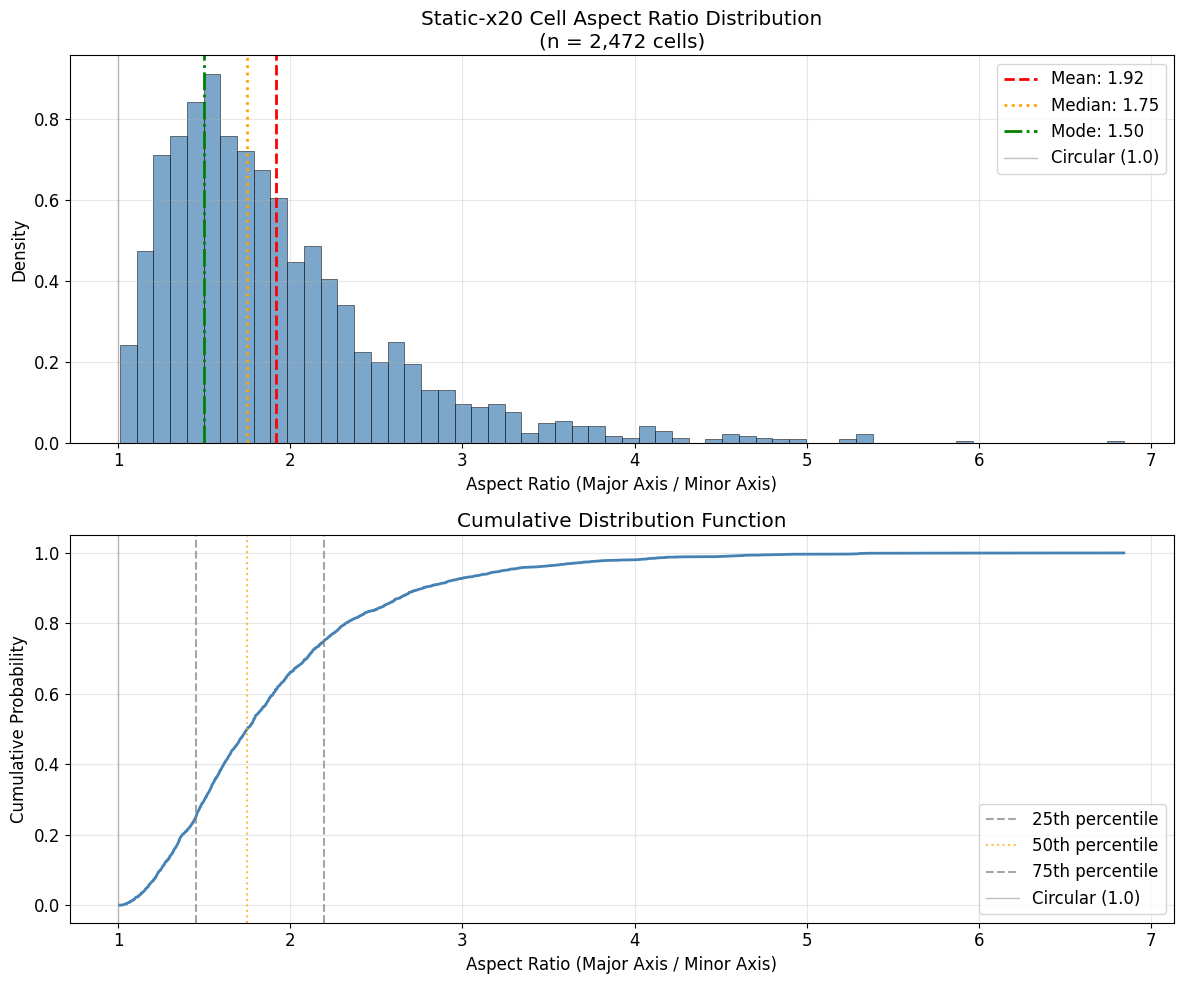

Main distribution plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/static_x20_cell_aspect_ratio_distribution.png


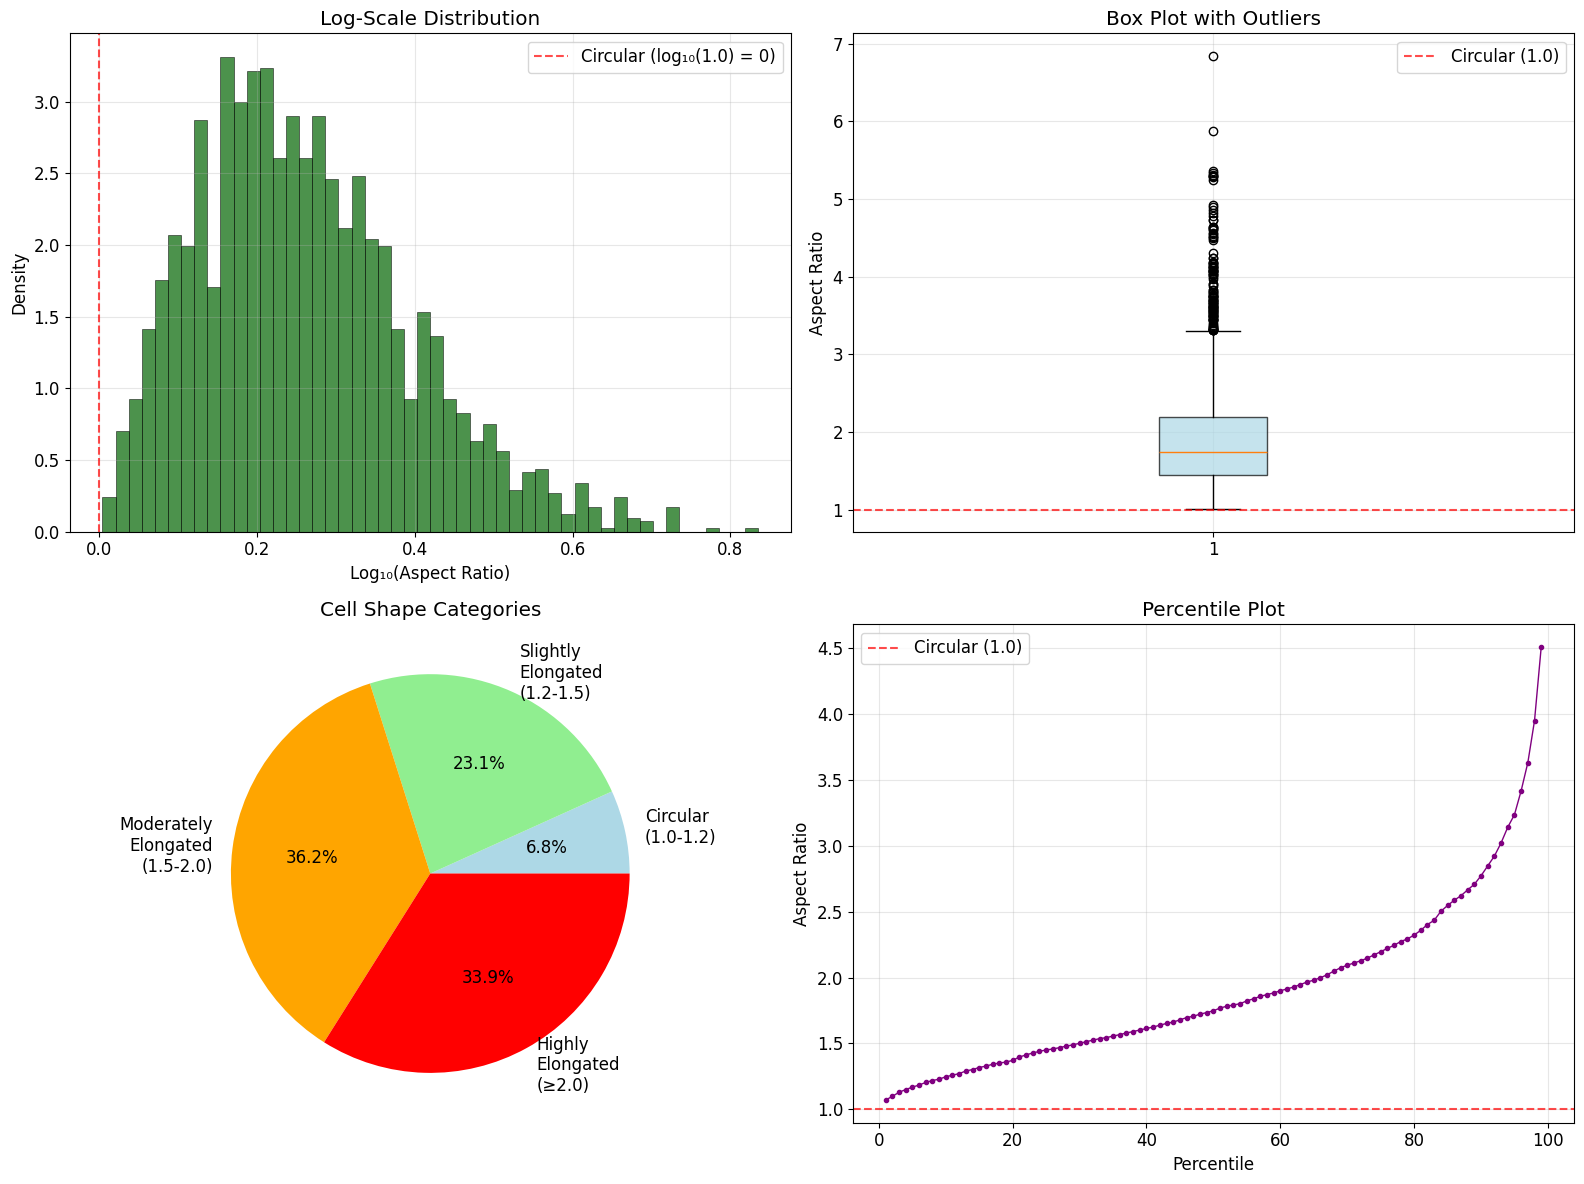

Detailed analysis plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/static_x20_aspect_ratio_detailed_analysis.png

STATIC-X20 CELL ASPECT RATIO STATISTICS

STATIC-X20 ANALYSIS:
  Sample size: 2,472 cells
  Total images processed: 8
  Average cells per image: 309.0

CENTRAL TENDENCIES:
  Mean: 1.917
  Median: 1.748
  Mode (most frequent): 1.50

VARIABILITY:
  Standard Deviation: 0.687
  Coefficient of Variation: 35.8%
  Variance: 0.4713
  Range: 5.833
  Interquartile Range: 0.744

EXTREMES:
  Minimum: 1.010
  Maximum: 6.842
  1st percentile: 1.071
  99th percentile: 4.506

QUARTILES:
  25th percentile (Q1): 1.451
  50th percentile (Q2/Median): 1.748
  75th percentile (Q3): 2.195

DISTRIBUTION SHAPE:
  Skewness: 1.777
    → Right-skewed (more highly elongated cells)
  Kurtosis: 4.723
    → Heavy-tailed (more extreme aspect ratios)

NORMALITY TEST:
  Shapiro-Wilk test statistic: 0.860090
  Shapiro-Wilk test p-value: 2.13e-42
    → Distribution is not normal (

In [5]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skimage.measure import regionprops

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def extract_cell_aspect_ratios(tif_path):
    """
    Extract individual cell aspect ratios from segmentation TIF file.
    Returns list of aspect ratios (major_axis / minor_axis).
    """
    try:
        # Try reading with PIL first
        img = Image.open(tif_path)
        img_array = np.array(img)
    except Exception as e:
        try:
            # Fallback to OpenCV
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None

    if img_array is None:
        return None

    try:
        # Use regionprops to measure individual cell properties
        regions = regionprops(img_array)

        # Extract aspect ratios (major_axis_length / minor_axis_length)
        aspect_ratios = []
        for region in regions:
            if region.minor_axis_length > 0:  # Avoid division by zero
                aspect_ratio = region.major_axis_length / region.minor_axis_length
                aspect_ratios.append(aspect_ratio)

        return aspect_ratios

    except Exception as e:
        print(f"Error processing regions in {tif_path}: {e}")
        return None

def create_static_x20_aspect_ratio_plot(aspect_ratios, base_path):
    """Create distribution plot for Static-x20 cell aspect ratios"""

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Main histogram
    ax1.hist(aspect_ratios, bins=60, density=True, alpha=0.7, color='steelblue',
             edgecolor='black', linewidth=0.5)

    # Add statistics lines
    mean_val = np.mean(aspect_ratios)
    median_val = np.median(aspect_ratios)
    mode_val = stats.mode(np.round(aspect_ratios, 1), keepdims=True)[0][0]

    ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.2f}')
    ax1.axvline(median_val, color='orange', linestyle=':', linewidth=2,
                label=f'Median: {median_val:.2f}')
    ax1.axvline(mode_val, color='green', linestyle='-.', linewidth=2,
                label=f'Mode: {mode_val:.2f}')

    # Add reference line for circular cells (aspect ratio = 1)
    ax1.axvline(1.0, color='gray', linestyle='-', alpha=0.5, linewidth=1,
                label='Circular (1.0)')

    # Formatting
    ax1.set_xlabel('Aspect Ratio (Major Axis / Minor Axis)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'Static-x20 Cell Aspect Ratio Distribution\n(n = {len(aspect_ratios):,} cells)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_ratios = np.sort(aspect_ratios)
    cumulative = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
    ax2.plot(sorted_ratios, cumulative, linewidth=2, color='steelblue')

    # Add percentile lines
    p25 = np.percentile(aspect_ratios, 25)
    p50 = np.percentile(aspect_ratios, 50)
    p75 = np.percentile(aspect_ratios, 75)

    ax2.axvline(p25, color='gray', linestyle='--', alpha=0.7, label='25th percentile')
    ax2.axvline(p50, color='orange', linestyle=':', alpha=0.7, label='50th percentile')
    ax2.axvline(p75, color='gray', linestyle='--', alpha=0.7, label='75th percentile')
    ax2.axvline(1.0, color='gray', linestyle='-', alpha=0.5, linewidth=1,
                label='Circular (1.0)')

    ax2.set_xlabel('Aspect Ratio (Major Axis / Minor Axis)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Function')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(base_path, "static_x20_cell_aspect_ratio_distribution.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_path

def create_detailed_aspect_ratio_analysis(aspect_ratios, base_path):
    """Create detailed analysis plots for aspect ratios"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Log-scale histogram
    log_ratios = np.log10(aspect_ratios)
    ax1.hist(log_ratios, bins=50, density=True, alpha=0.7, color='darkgreen',
             edgecolor='black', linewidth=0.5)
    ax1.axvline(np.log10(1.0), color='red', linestyle='--', alpha=0.7,
                label='Circular (log₁₀(1.0) = 0)')
    ax1.set_xlabel('Log₁₀(Aspect Ratio)')
    ax1.set_ylabel('Density')
    ax1.set_title('Log-Scale Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot with outliers
    bp = ax2.boxplot(aspect_ratios, patch_artist=True, showfliers=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax2.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Circular (1.0)')
    ax2.set_ylabel('Aspect Ratio')
    ax2.set_title('Box Plot with Outliers')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Shape categories pie chart
    circular = len([r for r in aspect_ratios if 1.0 <= r < 1.2])
    slightly_elongated = len([r for r in aspect_ratios if 1.2 <= r < 1.5])
    moderately_elongated = len([r for r in aspect_ratios if 1.5 <= r < 2.0])
    highly_elongated = len([r for r in aspect_ratios if r >= 2.0])

    categories = ['Circular\n(1.0-1.2)', 'Slightly\nElongated\n(1.2-1.5)',
                  'Moderately\nElongated\n(1.5-2.0)', 'Highly\nElongated\n(≥2.0)']
    counts = [circular, slightly_elongated, moderately_elongated, highly_elongated]
    colors = ['lightblue', 'lightgreen', 'orange', 'red']

    wedges, texts, autotexts = ax3.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%')
    ax3.set_title('Cell Shape Categories')

    # Plot 4: Percentile plot
    percentiles = np.arange(1, 100, 1)
    perc_values = [np.percentile(aspect_ratios, p) for p in percentiles]
    ax4.plot(percentiles, perc_values, 'o-', linewidth=1, markersize=3, color='purple')
    ax4.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Circular (1.0)')
    ax4.set_xlabel('Percentile')
    ax4.set_ylabel('Aspect Ratio')
    ax4.set_title('Percentile Plot')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    analysis_path = os.path.join(base_path, "static_x20_aspect_ratio_detailed_analysis.png")
    plt.savefig(analysis_path, dpi=300, bbox_inches='tight')
    plt.show()

    return analysis_path

# Main analysis code - FOCUS ON Static-x20 ONLY
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
static_folder = "flow3-x20"  # This is the Static-x20 folder
subfolder_name = "Cell_merged_conservative"

print("Starting cell aspect ratio analysis for Static-x20 only...")
print("="*60)

folder_path = os.path.join(base_path, static_folder, subfolder_name)
print(f"\nProcessing Static-x20 folder: {folder_path}")

if not os.path.exists(folder_path):
    print(f"Error: Path '{folder_path}' not found.")
    print("Please check that the folder exists.")
    exit()

tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

if not tif_files:
    print(f"No TIF files found in {folder_path}")
    exit()

print(f"Found {len(tif_files)} TIF file(s)")

# Store all cell aspect ratios for Static-x20
static_aspect_ratios = []

# Process each TIF file
for tif_file in tif_files:
    file_name = os.path.basename(tif_file)
    print(f"  Processing: {file_name}")

    aspect_ratios = extract_cell_aspect_ratios(tif_file)

    if aspect_ratios is not None:
        static_aspect_ratios.extend(aspect_ratios)
        print(f"    Found {len(aspect_ratios)} cells")
        print(f"    Mean aspect ratio in this image: {np.mean(aspect_ratios):.2f}")
    else:
        print(f"    Failed to process {file_name}")

# Analyze results if we have data
if static_aspect_ratios:
    print("\n" + "="*80)
    print("CREATING STATIC-X20 CELL ASPECT RATIO DISTRIBUTION PLOTS")
    print("="*80)

    # Create main distribution plot
    plot1_path = create_static_x20_aspect_ratio_plot(static_aspect_ratios, base_path)
    print(f"Main distribution plot saved: {plot1_path}")

    # Create detailed analysis plot
    plot2_path = create_detailed_aspect_ratio_analysis(static_aspect_ratios, base_path)
    print(f"Detailed analysis plot saved: {plot2_path}")

    # Print comprehensive statistics
    print("\n" + "="*60)
    print("STATIC-X20 CELL ASPECT RATIO STATISTICS")
    print("="*60)

    ratios = static_aspect_ratios
    print(f"\nSTATIC-X20 ANALYSIS:")
    print(f"  Sample size: {len(ratios):,} cells")
    print(f"  Total images processed: {len(tif_files)}")
    print(f"  Average cells per image: {len(ratios)/len(tif_files):.1f}")

    print(f"\nCENTRAL TENDENCIES:")
    print(f"  Mean: {np.mean(ratios):.3f}")
    print(f"  Median: {np.median(ratios):.3f}")
    print(f"  Mode (most frequent): {stats.mode(np.round(ratios, 1), keepdims=True)[0][0]:.2f}")

    print(f"\nVARIABILITY:")
    print(f"  Standard Deviation: {np.std(ratios):.3f}")
    print(f"  Coefficient of Variation: {(np.std(ratios)/np.mean(ratios)*100):.1f}%")
    print(f"  Variance: {np.var(ratios):.4f}")
    print(f"  Range: {np.max(ratios) - np.min(ratios):.3f}")
    print(f"  Interquartile Range: {np.percentile(ratios, 75) - np.percentile(ratios, 25):.3f}")

    print(f"\nEXTREMES:")
    print(f"  Minimum: {np.min(ratios):.3f}")
    print(f"  Maximum: {np.max(ratios):.3f}")
    print(f"  1st percentile: {np.percentile(ratios, 1):.3f}")
    print(f"  99th percentile: {np.percentile(ratios, 99):.3f}")

    print(f"\nQUARTILES:")
    print(f"  25th percentile (Q1): {np.percentile(ratios, 25):.3f}")
    print(f"  50th percentile (Q2/Median): {np.percentile(ratios, 50):.3f}")
    print(f"  75th percentile (Q3): {np.percentile(ratios, 75):.3f}")

    print(f"\nDISTRIBUTION SHAPE:")
    print(f"  Skewness: {stats.skew(ratios):.3f}")
    if stats.skew(ratios) > 0:
        print(f"    → Right-skewed (more highly elongated cells)")
    elif stats.skew(ratios) < 0:
        print(f"    → Left-skewed (more circular cells)")
    else:
        print(f"    → Approximately symmetric")

    print(f"  Kurtosis: {stats.kurtosis(ratios):.3f}")
    if stats.kurtosis(ratios) > 0:
        print(f"    → Heavy-tailed (more extreme aspect ratios)")
    elif stats.kurtosis(ratios) < 0:
        print(f"    → Light-tailed (fewer extreme aspect ratios)")
    else:
        print(f"    → Similar to normal distribution")

    print(f"\nNORMALITY TEST:")
    # Use subset if too many data points
    test_data = ratios if len(ratios) <= 5000 else np.random.choice(ratios, 5000, replace=False)
    try:
        shapiro_stat, shapiro_p = stats.shapiro(test_data)
        print(f"  Shapiro-Wilk test statistic: {shapiro_stat:.6f}")
        print(f"  Shapiro-Wilk test p-value: {shapiro_p:.2e}")
        if shapiro_p > 0.05:
            print(f"    → Distribution appears normal (p > 0.05)")
        else:
            print(f"    → Distribution is not normal (p ≤ 0.05)")
    except Exception as e:
        print(f"    → Could not perform normality test: {e}")

    print(f"\nCELL SHAPE CATEGORIES:")
    circular = len([r for r in ratios if 1.0 <= r < 1.2])
    slightly_elongated = len([r for r in ratios if 1.2 <= r < 1.5])
    moderately_elongated = len([r for r in ratios if 1.5 <= r < 2.0])
    highly_elongated = len([r for r in ratios if r >= 2.0])

    print(f"  Circular (1.0-1.2): {circular:,} cells ({circular/len(ratios)*100:.1f}%)")
    print(f"  Slightly elongated (1.2-1.5): {slightly_elongated:,} cells ({slightly_elongated/len(ratios)*100:.1f}%)")
    print(f"  Moderately elongated (1.5-2.0): {moderately_elongated:,} cells ({moderately_elongated/len(ratios)*100:.1f}%)")
    print(f"  Highly elongated (≥2.0): {highly_elongated:,} cells ({highly_elongated/len(ratios)*100:.1f}%)")

    # Define outliers using IQR method
    q1, q3 = np.percentile(ratios, 25), np.percentile(ratios, 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outliers = [r for r in ratios if r < lower_fence or r > upper_fence]
    print(f"\nOUTLIER ANALYSIS:")
    print(f"  Outliers (beyond 1.5×IQR): {len(outliers):,} cells ({len(outliers)/len(ratios)*100:.1f}%)")
    print(f"  Lower fence: {lower_fence:.3f}")
    print(f"  Upper fence: {upper_fence:.3f}")
    if len(outliers) > 0:
        print(f"  Most extreme outlier: {max(ratios):.3f}")

    print(f"\nCIRCULARITY ANALYSIS:")
    near_circular = len([r for r in ratios if 1.0 <= r <= 1.1])
    print(f"  Nearly circular cells (1.0-1.1): {near_circular:,} ({near_circular/len(ratios)*100:.1f}%)")
    print(f"  Cells with aspect ratio > 1.5: {len([r for r in ratios if r > 1.5]):,} ({len([r for r in ratios if r > 1.5])/len(ratios)*100:.1f}%)")
    print(f"  Cells with aspect ratio > 2.0: {len([r for r in ratios if r > 2.0]):,} ({len([r for r in ratios if r > 2.0])/len(ratios)*100:.1f}%)")

    print(f"\n" + "="*80)
    print("STATIC-X20 ASPECT RATIO ANALYSIS COMPLETE")
    print("="*80)
    print("Plots created:")
    print(f"1. Main distribution plot: {plot1_path}")
    print(f"2. Detailed analysis plot: {plot2_path}")
    print(f"\nNote: Aspect ratio = Major axis / Minor axis")
    print(f"- Value of 1.0 = perfectly circular cell")
    print(f"- Higher values = more elongated cells")
    print(f"Total cells analyzed: {len(static_aspect_ratios):,}")

else:
    print("No cell aspect ratio data found for Static-x20.")
    print(f"Please check that TIF files exist in: {folder_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting cell aspect ratio analysis for 1.4Pa-x20 only...

Processing 1.4Pa-x20 folder: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/1.4Pa-x20/Cell_merged_conservative
Found 23 TIF file(s)
  Processing: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_cell_mask_merged_conservative.tif
    Found 326 cells
    Mean aspect ratio in this image: 1.76
  Processing: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq002_cell_mask_merged_conservative.tif
    Found 273 cells
    Mean aspect ratio in this image: 1.83
  Processing: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq004_cell_mask_merged_conservative.tif
    Found 276 cells
    Mean aspect ratio in this image: 1.92
  Processing: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq003_cell_mask_merged_conservative.tif
    Found 276 cells
    Mean aspect ratio in this image: 1.88
  Processing: 1.4Pa_A1_1

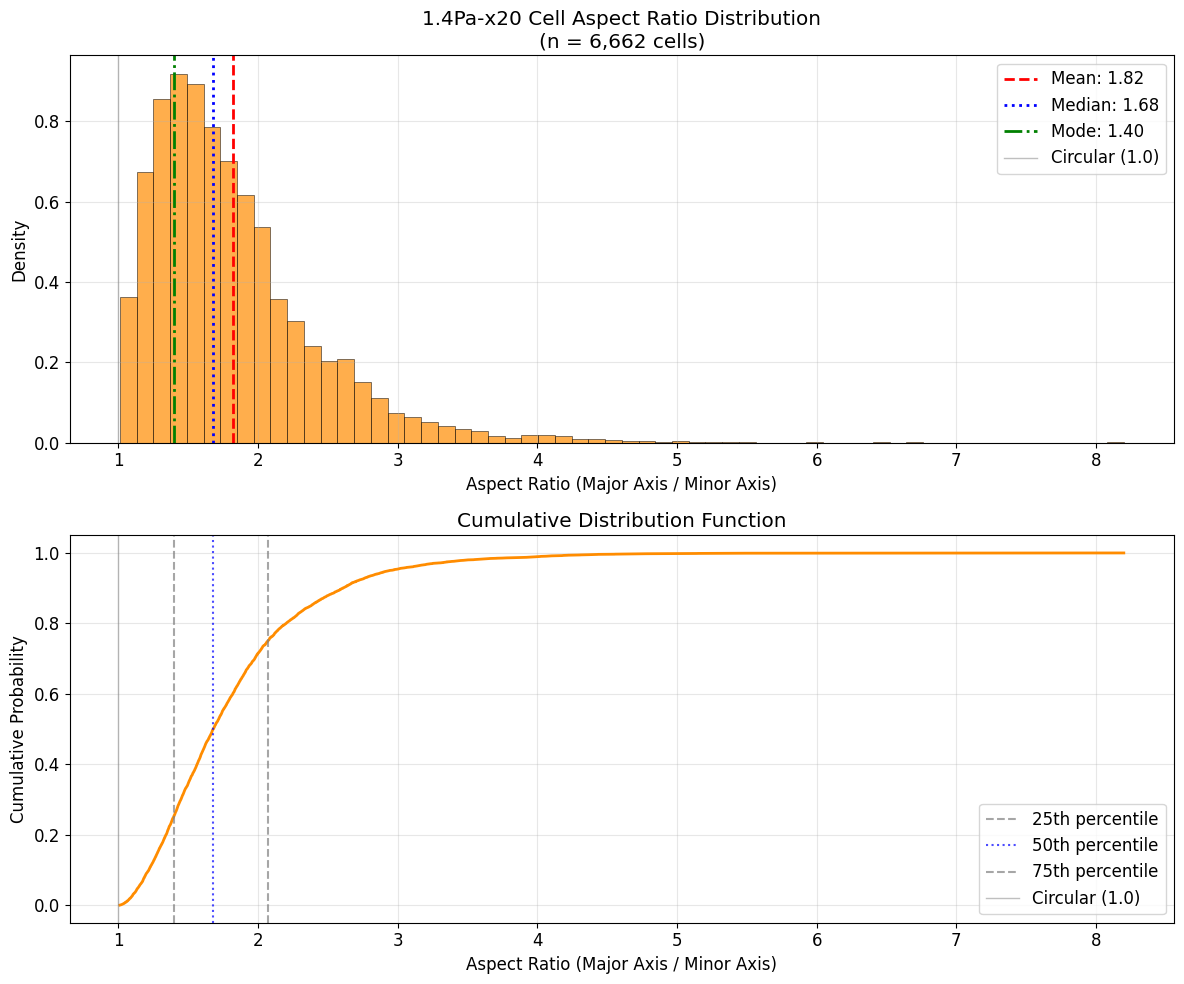

Main distribution plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/1p4pa_x20_cell_aspect_ratio_distribution.png


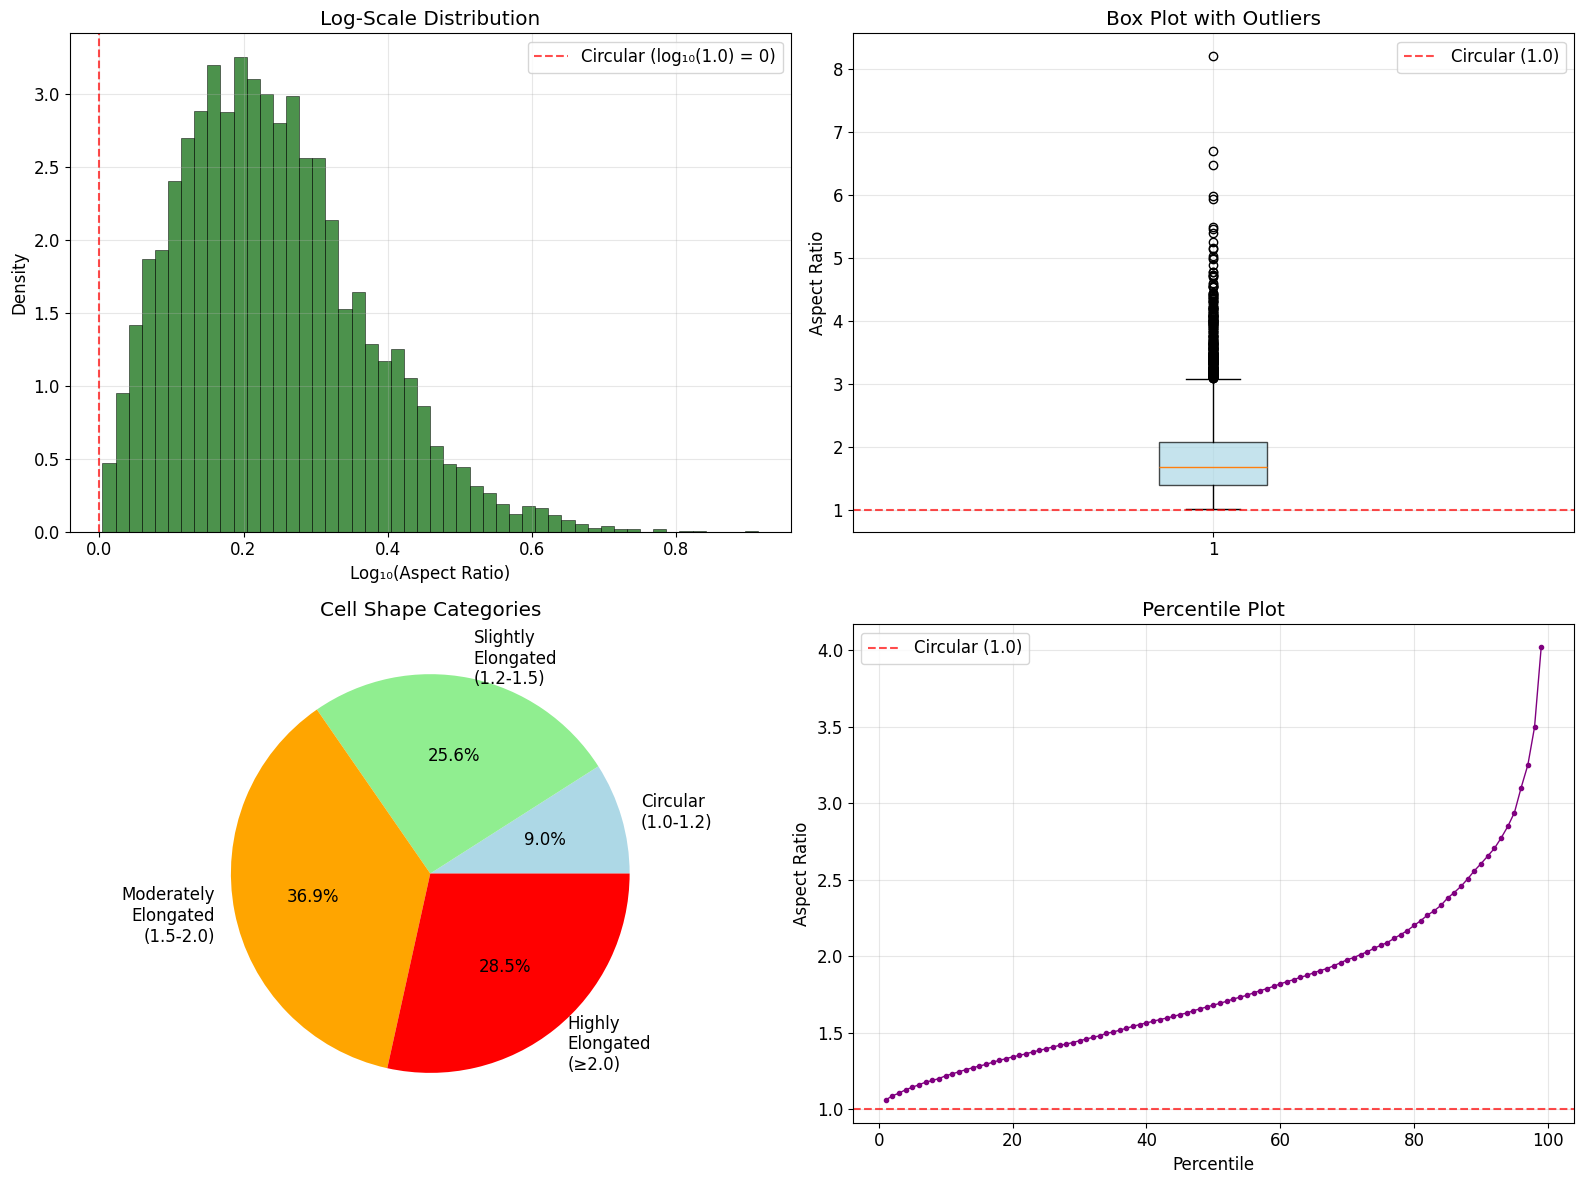

Detailed analysis plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/1p4pa_x20_aspect_ratio_detailed_analysis.png

1.4Pa-x20 CELL ASPECT RATIO STATISTICS

1.4Pa-x20 ANALYSIS:
  Sample size: 6,662 cells
  Total images processed: 23
  Average cells per image: 289.7

CENTRAL TENDENCIES:
  Mean: 1.820
  Median: 1.679
  Mode (most frequent): 1.40

VARIABILITY:
  Standard Deviation: 0.610
  Coefficient of Variation: 33.5%
  Variance: 0.3720
  Range: 7.189
  Interquartile Range: 0.676

EXTREMES:
  Minimum: 1.010
  Maximum: 8.199
  1st percentile: 1.058
  99th percentile: 4.021

QUARTILES:
  25th percentile (Q1): 1.394
  50th percentile (Q2/Median): 1.679
  75th percentile (Q3): 2.070

DISTRIBUTION SHAPE:
  Skewness: 1.893
    → Right-skewed (more highly elongated cells)
  Kurtosis: 6.739
    → Heavy-tailed (more extreme aspect ratios)

NORMALITY TEST:
  Shapiro-Wilk test statistic: 0.855432
  Shapiro-Wilk test p-value: 1.29e-55
    → Distribution is not normal (p 

In [6]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skimage.measure import regionprops

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def extract_cell_aspect_ratios(tif_path):
    """
    Extract individual cell aspect ratios from segmentation TIF file.
    Returns list of aspect ratios (major_axis / minor_axis).
    """
    try:
        # Try reading with PIL first
        img = Image.open(tif_path)
        img_array = np.array(img)
    except Exception as e:
        try:
            # Fallback to OpenCV
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None

    if img_array is None:
        return None

    try:
        # Use regionprops to measure individual cell properties
        regions = regionprops(img_array)

        # Extract aspect ratios (major_axis_length / minor_axis_length)
        aspect_ratios = []
        for region in regions:
            if region.minor_axis_length > 0:  # Avoid division by zero
                aspect_ratio = region.major_axis_length / region.minor_axis_length
                aspect_ratios.append(aspect_ratio)

        return aspect_ratios

    except Exception as e:
        print(f"Error processing regions in {tif_path}: {e}")
        return None

def create_1p4pa_x20_aspect_ratio_plot(aspect_ratios, base_path):
    """Create distribution plot for 1.4Pa-x20 cell aspect ratios"""

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Main histogram
    ax1.hist(aspect_ratios, bins=60, density=True, alpha=0.7, color='darkorange',
             edgecolor='black', linewidth=0.5)

    # Add statistics lines
    mean_val = np.mean(aspect_ratios)
    median_val = np.median(aspect_ratios)
    mode_val = stats.mode(np.round(aspect_ratios, 1), keepdims=True)[0][0]

    ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.2f}')
    ax1.axvline(median_val, color='blue', linestyle=':', linewidth=2,
                label=f'Median: {median_val:.2f}')
    ax1.axvline(mode_val, color='green', linestyle='-.', linewidth=2,
                label=f'Mode: {mode_val:.2f}')

    # Add reference line for circular cells (aspect ratio = 1)
    ax1.axvline(1.0, color='gray', linestyle='-', alpha=0.5, linewidth=1,
                label='Circular (1.0)')

    # Formatting
    ax1.set_xlabel('Aspect Ratio (Major Axis / Minor Axis)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'1.4Pa-x20 Cell Aspect Ratio Distribution\n(n = {len(aspect_ratios):,} cells)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_ratios = np.sort(aspect_ratios)
    cumulative = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
    ax2.plot(sorted_ratios, cumulative, linewidth=2, color='darkorange')

    # Add percentile lines
    p25 = np.percentile(aspect_ratios, 25)
    p50 = np.percentile(aspect_ratios, 50)
    p75 = np.percentile(aspect_ratios, 75)

    ax2.axvline(p25, color='gray', linestyle='--', alpha=0.7, label='25th percentile')
    ax2.axvline(p50, color='blue', linestyle=':', alpha=0.7, label='50th percentile')
    ax2.axvline(p75, color='gray', linestyle='--', alpha=0.7, label='75th percentile')
    ax2.axvline(1.0, color='gray', linestyle='-', alpha=0.5, linewidth=1,
                label='Circular (1.0)')

    ax2.set_xlabel('Aspect Ratio (Major Axis / Minor Axis)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Function')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(base_path, "1p4pa_x20_cell_aspect_ratio_distribution.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_path

def create_detailed_aspect_ratio_analysis(aspect_ratios, base_path):
    """Create detailed analysis plots for aspect ratios"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Log-scale histogram
    log_ratios = np.log10(aspect_ratios)
    ax1.hist(log_ratios, bins=50, density=True, alpha=0.7, color='darkgreen',
             edgecolor='black', linewidth=0.5)
    ax1.axvline(np.log10(1.0), color='red', linestyle='--', alpha=0.7,
                label='Circular (log₁₀(1.0) = 0)')
    ax1.set_xlabel('Log₁₀(Aspect Ratio)')
    ax1.set_ylabel('Density')
    ax1.set_title('Log-Scale Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot with outliers
    bp = ax2.boxplot(aspect_ratios, patch_artist=True, showfliers=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax2.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Circular (1.0)')
    ax2.set_ylabel('Aspect Ratio')
    ax2.set_title('Box Plot with Outliers')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Shape categories pie chart
    circular = len([r for r in aspect_ratios if 1.0 <= r < 1.2])
    slightly_elongated = len([r for r in aspect_ratios if 1.2 <= r < 1.5])
    moderately_elongated = len([r for r in aspect_ratios if 1.5 <= r < 2.0])
    highly_elongated = len([r for r in aspect_ratios if r >= 2.0])

    categories = ['Circular\n(1.0-1.2)', 'Slightly\nElongated\n(1.2-1.5)',
                  'Moderately\nElongated\n(1.5-2.0)', 'Highly\nElongated\n(≥2.0)']
    counts = [circular, slightly_elongated, moderately_elongated, highly_elongated]
    colors = ['lightblue', 'lightgreen', 'orange', 'red']

    wedges, texts, autotexts = ax3.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%')
    ax3.set_title('Cell Shape Categories')

    # Plot 4: Percentile plot
    percentiles = np.arange(1, 100, 1)
    perc_values = [np.percentile(aspect_ratios, p) for p in percentiles]
    ax4.plot(percentiles, perc_values, 'o-', linewidth=1, markersize=3, color='purple')
    ax4.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Circular (1.0)')
    ax4.set_xlabel('Percentile')
    ax4.set_ylabel('Aspect Ratio')
    ax4.set_title('Percentile Plot')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    analysis_path = os.path.join(base_path, "1p4pa_x20_aspect_ratio_detailed_analysis.png")
    plt.savefig(analysis_path, dpi=300, bbox_inches='tight')
    plt.show()

    return analysis_path

# Main analysis code - FOCUS ON 1.4Pa-x20 ONLY
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
pressure_folder = "1.4Pa-x20"  # This is the 1.4Pa-x20 folder
subfolder_name = "Cell_merged_conservative"

print("Starting cell aspect ratio analysis for 1.4Pa-x20 only...")
print("="*60)

folder_path = os.path.join(base_path, pressure_folder, subfolder_name)
print(f"\nProcessing 1.4Pa-x20 folder: {folder_path}")

if not os.path.exists(folder_path):
    print(f"Error: Path '{folder_path}' not found.")
    print("Please check that the folder exists.")
    exit()

tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

if not tif_files:
    print(f"No TIF files found in {folder_path}")
    exit()

print(f"Found {len(tif_files)} TIF file(s)")

# Store all cell aspect ratios for 1.4Pa-x20
pressure_aspect_ratios = []

# Process each TIF file
for tif_file in tif_files:
    file_name = os.path.basename(tif_file)
    print(f"  Processing: {file_name}")

    aspect_ratios = extract_cell_aspect_ratios(tif_file)

    if aspect_ratios is not None:
        pressure_aspect_ratios.extend(aspect_ratios)
        print(f"    Found {len(aspect_ratios)} cells")
        print(f"    Mean aspect ratio in this image: {np.mean(aspect_ratios):.2f}")
    else:
        print(f"    Failed to process {file_name}")

# Analyze results if we have data
if pressure_aspect_ratios:
    print("\n" + "="*80)
    print("CREATING 1.4Pa-x20 CELL ASPECT RATIO DISTRIBUTION PLOTS")
    print("="*80)

    # Create main distribution plot
    plot1_path = create_1p4pa_x20_aspect_ratio_plot(pressure_aspect_ratios, base_path)
    print(f"Main distribution plot saved: {plot1_path}")

    # Create detailed analysis plot
    plot2_path = create_detailed_aspect_ratio_analysis(pressure_aspect_ratios, base_path)
    print(f"Detailed analysis plot saved: {plot2_path}")

    # Print comprehensive statistics
    print("\n" + "="*60)
    print("1.4Pa-x20 CELL ASPECT RATIO STATISTICS")
    print("="*60)

    ratios = pressure_aspect_ratios
    print(f"\n1.4Pa-x20 ANALYSIS:")
    print(f"  Sample size: {len(ratios):,} cells")
    print(f"  Total images processed: {len(tif_files)}")
    print(f"  Average cells per image: {len(ratios)/len(tif_files):.1f}")

    print(f"\nCENTRAL TENDENCIES:")
    print(f"  Mean: {np.mean(ratios):.3f}")
    print(f"  Median: {np.median(ratios):.3f}")
    print(f"  Mode (most frequent): {stats.mode(np.round(ratios, 1), keepdims=True)[0][0]:.2f}")

    print(f"\nVARIABILITY:")
    print(f"  Standard Deviation: {np.std(ratios):.3f}")
    print(f"  Coefficient of Variation: {(np.std(ratios)/np.mean(ratios)*100):.1f}%")
    print(f"  Variance: {np.var(ratios):.4f}")
    print(f"  Range: {np.max(ratios) - np.min(ratios):.3f}")
    print(f"  Interquartile Range: {np.percentile(ratios, 75) - np.percentile(ratios, 25):.3f}")

    print(f"\nEXTREMES:")
    print(f"  Minimum: {np.min(ratios):.3f}")
    print(f"  Maximum: {np.max(ratios):.3f}")
    print(f"  1st percentile: {np.percentile(ratios, 1):.3f}")
    print(f"  99th percentile: {np.percentile(ratios, 99):.3f}")

    print(f"\nQUARTILES:")
    print(f"  25th percentile (Q1): {np.percentile(ratios, 25):.3f}")
    print(f"  50th percentile (Q2/Median): {np.percentile(ratios, 50):.3f}")
    print(f"  75th percentile (Q3): {np.percentile(ratios, 75):.3f}")

    print(f"\nDISTRIBUTION SHAPE:")
    print(f"  Skewness: {stats.skew(ratios):.3f}")
    if stats.skew(ratios) > 0:
        print(f"    → Right-skewed (more highly elongated cells)")
    elif stats.skew(ratios) < 0:
        print(f"    → Left-skewed (more circular cells)")
    else:
        print(f"    → Approximately symmetric")

    print(f"  Kurtosis: {stats.kurtosis(ratios):.3f}")
    if stats.kurtosis(ratios) > 0:
        print(f"    → Heavy-tailed (more extreme aspect ratios)")
    elif stats.kurtosis(ratios) < 0:
        print(f"    → Light-tailed (fewer extreme aspect ratios)")
    else:
        print(f"    → Similar to normal distribution")

    print(f"\nNORMALITY TEST:")
    # Use subset if too many data points
    test_data = ratios if len(ratios) <= 5000 else np.random.choice(ratios, 5000, replace=False)
    try:
        shapiro_stat, shapiro_p = stats.shapiro(test_data)
        print(f"  Shapiro-Wilk test statistic: {shapiro_stat:.6f}")
        print(f"  Shapiro-Wilk test p-value: {shapiro_p:.2e}")
        if shapiro_p > 0.05:
            print(f"    → Distribution appears normal (p > 0.05)")
        else:
            print(f"    → Distribution is not normal (p ≤ 0.05)")
    except Exception as e:
        print(f"    → Could not perform normality test: {e}")

    print(f"\nCELL SHAPE CATEGORIES:")
    circular = len([r for r in ratios if 1.0 <= r < 1.2])
    slightly_elongated = len([r for r in ratios if 1.2 <= r < 1.5])
    moderately_elongated = len([r for r in ratios if 1.5 <= r < 2.0])
    highly_elongated = len([r for r in ratios if r >= 2.0])

    print(f"  Circular (1.0-1.2): {circular:,} cells ({circular/len(ratios)*100:.1f}%)")
    print(f"  Slightly elongated (1.2-1.5): {slightly_elongated:,} cells ({slightly_elongated/len(ratios)*100:.1f}%)")
    print(f"  Moderately elongated (1.5-2.0): {moderately_elongated:,} cells ({moderately_elongated/len(ratios)*100:.1f}%)")
    print(f"  Highly elongated (≥2.0): {highly_elongated:,} cells ({highly_elongated/len(ratios)*100:.1f}%)")

    # Define outliers using IQR method
    q1, q3 = np.percentile(ratios, 25), np.percentile(ratios, 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outliers = [r for r in ratios if r < lower_fence or r > upper_fence]
    print(f"\nOUTLIER ANALYSIS:")
    print(f"  Outliers (beyond 1.5×IQR): {len(outliers):,} cells ({len(outliers)/len(ratios)*100:.1f}%)")
    print(f"  Lower fence: {lower_fence:.3f}")
    print(f"  Upper fence: {upper_fence:.3f}")
    if len(outliers) > 0:
        print(f"  Most extreme outlier: {max(ratios):.3f}")

    print(f"\nCIRCULARITY ANALYSIS:")
    near_circular = len([r for r in ratios if 1.0 <= r <= 1.1])
    print(f"  Nearly circular cells (1.0-1.1): {near_circular:,} ({near_circular/len(ratios)*100:.1f}%)")
    print(f"  Cells with aspect ratio > 1.5: {len([r for r in ratios if r > 1.5]):,} ({len([r for r in ratios if r > 1.5])/len(ratios)*100:.1f}%)")
    print(f"  Cells with aspect ratio > 2.0: {len([r for r in ratios if r > 2.0]):,} ({len([r for r in ratios if r > 2.0])/len(ratios)*100:.1f}%)")

    print(f"\n" + "="*80)
    print("1.4Pa-x20 ASPECT RATIO ANALYSIS COMPLETE")
    print("="*80)
    print("Plots created:")
    print(f"1. Main distribution plot: {plot1_path}")
    print(f"2. Detailed analysis plot: {plot2_path}")
    print(f"\nNote: Aspect ratio = Major axis / Minor axis")
    print(f"- Value of 1.0 = perfectly circular cell")
    print(f"- Higher values = more elongated cells")
    print(f"Total cells analyzed: {len(pressure_aspect_ratios):,}")

else:
    print("No cell aspect ratio data found for 1.4Pa-x20.")
    print(f"Please check that TIF files exist in: {folder_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting cell aspect ratio analysis for 1.4Pa-x40 only...

Processing 1.4Pa-x40 folder: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/1.4Pa-x40/Cell_merged_conservative
Found 13 TIF file(s)
  Processing: 1.4Pa_A1_19dec21_40x_L2RA_FlatA_seq001_cell_mask_merged_conservative.tif
    Found 79 cells
    Mean aspect ratio in this image: 1.90
  Processing: 1.4Pa_A1_19dec21_40x_L2RA_FlatA_seq002_cell_mask_merged_conservative.tif
    Found 81 cells
    Mean aspect ratio in this image: 2.03
  Processing: 1.4Pa_A1_19dec21_40x_L2RA_FlatA_seq003_cell_mask_merged_conservative.tif
    Found 83 cells
    Mean aspect ratio in this image: 1.82
  Processing: 1.4Pa_A1_19dec21_40x_L2RA_FlatA_seq004_cell_mask_merged_conservative.tif
    Found 78 cells
    Mean aspect ratio in this image: 1.92
  Processing: 1.4Pa_A1_19dec21_4

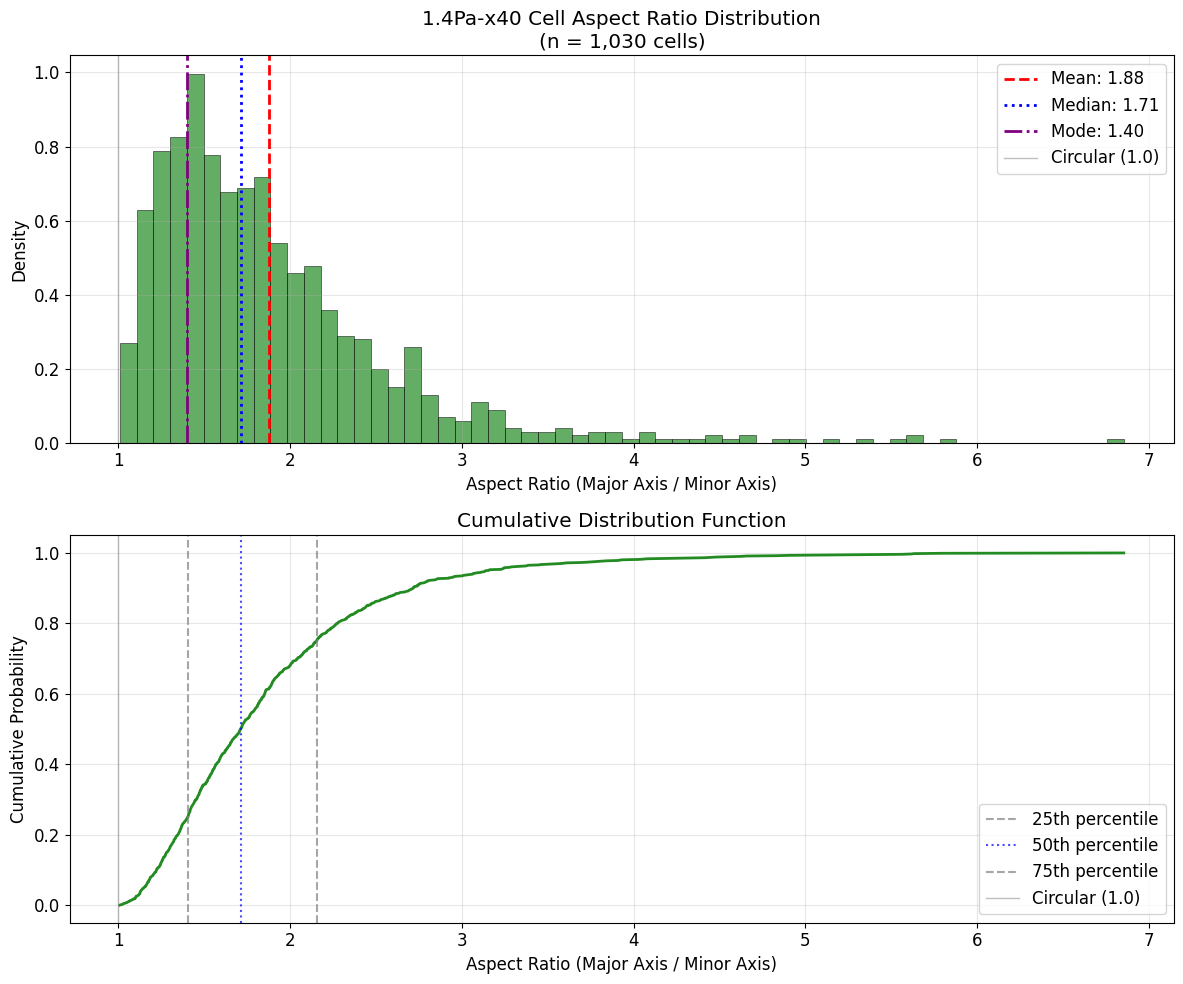

Main distribution plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/1p4pa_x40_cell_aspect_ratio_distribution.png


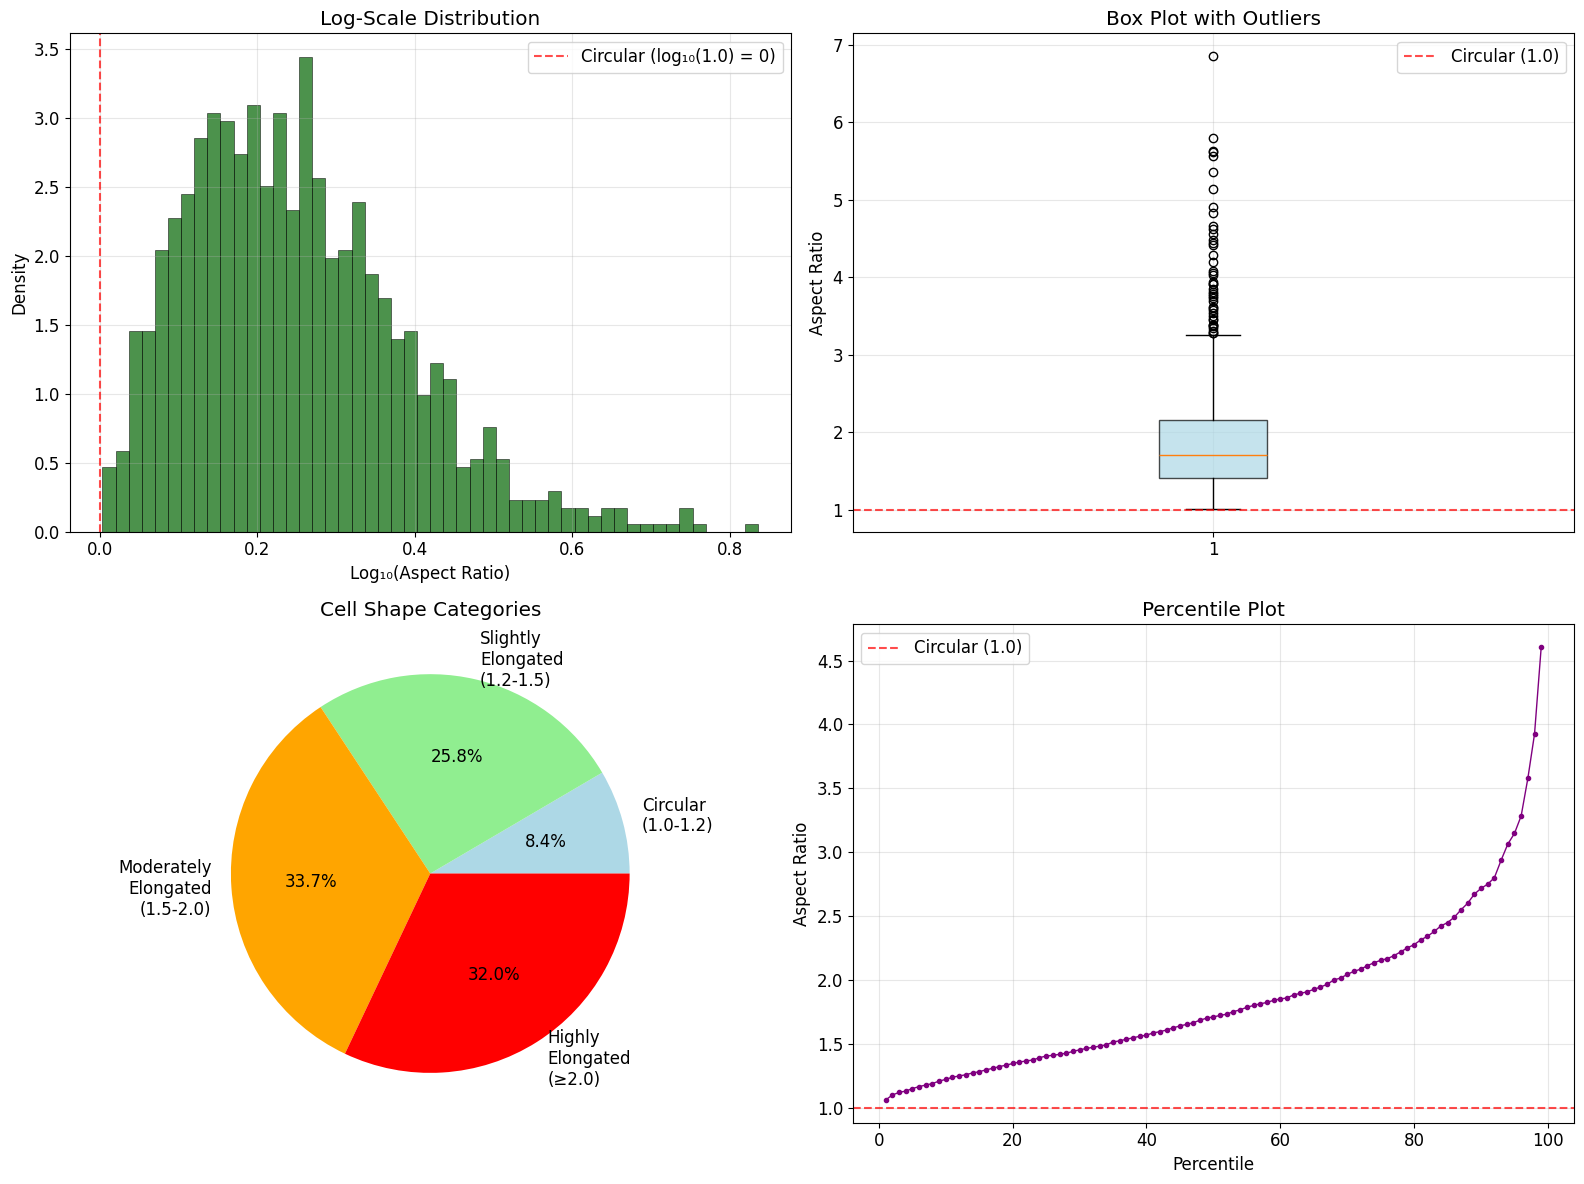

Detailed analysis plot saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/1p4pa_x40_aspect_ratio_detailed_analysis.png

1.4Pa-x40 CELL ASPECT RATIO STATISTICS

1.4Pa-x40 ANALYSIS:
  Sample size: 1,030 cells
  Total images processed: 13
  Average cells per image: 79.2

CENTRAL TENDENCIES:
  Mean: 1.877
  Median: 1.711
  Mode (most frequent): 1.40

VARIABILITY:
  Standard Deviation: 0.705
  Coefficient of Variation: 37.6%
  Variance: 0.4976
  Range: 5.846
  Interquartile Range: 0.749

EXTREMES:
  Minimum: 1.008
  Maximum: 6.854
  1st percentile: 1.059
  99th percentile: 4.606

QUARTILES:
  25th percentile (Q1): 1.404
  50th percentile (Q2/Median): 1.711
  75th percentile (Q3): 2.153

DISTRIBUTION SHAPE:
  Skewness: 2.162
    → Right-skewed (more highly elongated cells)
  Kurtosis: 7.390
    → Heavy-tailed (more extreme aspect ratios)

NORMALITY TEST:
  Shapiro-Wilk test statistic: 0.824910
  Shapiro-Wilk test p-value: 4.43e-32
    → Distribution is not normal (p ≤

In [7]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skimage.measure import regionprops

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def extract_cell_aspect_ratios(tif_path):
    """
    Extract individual cell aspect ratios from segmentation TIF file.
    Returns list of aspect ratios (major_axis / minor_axis).
    """
    try:
        # Try reading with PIL first
        img = Image.open(tif_path)
        img_array = np.array(img)
    except Exception as e:
        try:
            # Fallback to OpenCV
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None

    if img_array is None:
        return None

    try:
        # Use regionprops to measure individual cell properties
        regions = regionprops(img_array)

        # Extract aspect ratios (major_axis_length / minor_axis_length)
        aspect_ratios = []
        for region in regions:
            if region.minor_axis_length > 0:  # Avoid division by zero
                aspect_ratio = region.major_axis_length / region.minor_axis_length
                aspect_ratios.append(aspect_ratio)

        return aspect_ratios

    except Exception as e:
        print(f"Error processing regions in {tif_path}: {e}")
        return None

def create_1p4pa_x40_aspect_ratio_plot(aspect_ratios, base_path):
    """Create distribution plot for 1.4Pa-x40 cell aspect ratios"""

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Main histogram
    ax1.hist(aspect_ratios, bins=60, density=True, alpha=0.7, color='forestgreen',
             edgecolor='black', linewidth=0.5)

    # Add statistics lines
    mean_val = np.mean(aspect_ratios)
    median_val = np.median(aspect_ratios)
    mode_val = stats.mode(np.round(aspect_ratios, 1), keepdims=True)[0][0]

    ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.2f}')
    ax1.axvline(median_val, color='blue', linestyle=':', linewidth=2,
                label=f'Median: {median_val:.2f}')
    ax1.axvline(mode_val, color='purple', linestyle='-.', linewidth=2,
                label=f'Mode: {mode_val:.2f}')

    # Add reference line for circular cells (aspect ratio = 1)
    ax1.axvline(1.0, color='gray', linestyle='-', alpha=0.5, linewidth=1,
                label='Circular (1.0)')

    # Formatting
    ax1.set_xlabel('Aspect Ratio (Major Axis / Minor Axis)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'1.4Pa-x40 Cell Aspect Ratio Distribution\n(n = {len(aspect_ratios):,} cells)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_ratios = np.sort(aspect_ratios)
    cumulative = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios)
    ax2.plot(sorted_ratios, cumulative, linewidth=2, color='forestgreen')

    # Add percentile lines
    p25 = np.percentile(aspect_ratios, 25)
    p50 = np.percentile(aspect_ratios, 50)
    p75 = np.percentile(aspect_ratios, 75)

    ax2.axvline(p25, color='gray', linestyle='--', alpha=0.7, label='25th percentile')
    ax2.axvline(p50, color='blue', linestyle=':', alpha=0.7, label='50th percentile')
    ax2.axvline(p75, color='gray', linestyle='--', alpha=0.7, label='75th percentile')
    ax2.axvline(1.0, color='gray', linestyle='-', alpha=0.5, linewidth=1,
                label='Circular (1.0)')

    ax2.set_xlabel('Aspect Ratio (Major Axis / Minor Axis)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Function')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(base_path, "1p4pa_x40_cell_aspect_ratio_distribution.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    return plot_path

def create_detailed_aspect_ratio_analysis(aspect_ratios, base_path):
    """Create detailed analysis plots for aspect ratios"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Log-scale histogram
    log_ratios = np.log10(aspect_ratios)
    ax1.hist(log_ratios, bins=50, density=True, alpha=0.7, color='darkgreen',
             edgecolor='black', linewidth=0.5)
    ax1.axvline(np.log10(1.0), color='red', linestyle='--', alpha=0.7,
                label='Circular (log₁₀(1.0) = 0)')
    ax1.set_xlabel('Log₁₀(Aspect Ratio)')
    ax1.set_ylabel('Density')
    ax1.set_title('Log-Scale Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot with outliers
    bp = ax2.boxplot(aspect_ratios, patch_artist=True, showfliers=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax2.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Circular (1.0)')
    ax2.set_ylabel('Aspect Ratio')
    ax2.set_title('Box Plot with Outliers')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Shape categories pie chart
    circular = len([r for r in aspect_ratios if 1.0 <= r < 1.2])
    slightly_elongated = len([r for r in aspect_ratios if 1.2 <= r < 1.5])
    moderately_elongated = len([r for r in aspect_ratios if 1.5 <= r < 2.0])
    highly_elongated = len([r for r in aspect_ratios if r >= 2.0])

    categories = ['Circular\n(1.0-1.2)', 'Slightly\nElongated\n(1.2-1.5)',
                  'Moderately\nElongated\n(1.5-2.0)', 'Highly\nElongated\n(≥2.0)']
    counts = [circular, slightly_elongated, moderately_elongated, highly_elongated]
    colors = ['lightblue', 'lightgreen', 'orange', 'red']

    wedges, texts, autotexts = ax3.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%')
    ax3.set_title('Cell Shape Categories')

    # Plot 4: Percentile plot
    percentiles = np.arange(1, 100, 1)
    perc_values = [np.percentile(aspect_ratios, p) for p in percentiles]
    ax4.plot(percentiles, perc_values, 'o-', linewidth=1, markersize=3, color='purple')
    ax4.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Circular (1.0)')
    ax4.set_xlabel('Percentile')
    ax4.set_ylabel('Aspect Ratio')
    ax4.set_title('Percentile Plot')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    analysis_path = os.path.join(base_path, "1p4pa_x40_aspect_ratio_detailed_analysis.png")
    plt.savefig(analysis_path, dpi=300, bbox_inches='tight')
    plt.show()

    return analysis_path

# Main analysis code - FOCUS ON 1.4Pa-x40 ONLY
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
pressure_folder = "1.4Pa-x40"  # This is the 1.4Pa-x40 folder
subfolder_name = "Cell_merged_conservative"

print("Starting cell aspect ratio analysis for 1.4Pa-x40 only...")
print("="*60)

folder_path = os.path.join(base_path, pressure_folder, subfolder_name)
print(f"\nProcessing 1.4Pa-x40 folder: {folder_path}")

if not os.path.exists(folder_path):
    print(f"Error: Path '{folder_path}' not found.")
    print("Please check that the folder exists.")
    exit()

tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

if not tif_files:
    print(f"No TIF files found in {folder_path}")
    exit()

print(f"Found {len(tif_files)} TIF file(s)")

# Store all cell aspect ratios for 1.4Pa-x40
x40_aspect_ratios = []

# Process each TIF file
for tif_file in tif_files:
    file_name = os.path.basename(tif_file)
    print(f"  Processing: {file_name}")

    aspect_ratios = extract_cell_aspect_ratios(tif_file)

    if aspect_ratios is not None:
        x40_aspect_ratios.extend(aspect_ratios)
        print(f"    Found {len(aspect_ratios)} cells")
        print(f"    Mean aspect ratio in this image: {np.mean(aspect_ratios):.2f}")
    else:
        print(f"    Failed to process {file_name}")

# Analyze results if we have data
if x40_aspect_ratios:
    print("\n" + "="*80)
    print("CREATING 1.4Pa-x40 CELL ASPECT RATIO DISTRIBUTION PLOTS")
    print("="*80)

    # Create main distribution plot
    plot1_path = create_1p4pa_x40_aspect_ratio_plot(x40_aspect_ratios, base_path)
    print(f"Main distribution plot saved: {plot1_path}")

    # Create detailed analysis plot
    plot2_path = create_detailed_aspect_ratio_analysis(x40_aspect_ratios, base_path)
    print(f"Detailed analysis plot saved: {plot2_path}")

    # Print comprehensive statistics
    print("\n" + "="*60)
    print("1.4Pa-x40 CELL ASPECT RATIO STATISTICS")
    print("="*60)

    ratios = x40_aspect_ratios
    print(f"\n1.4Pa-x40 ANALYSIS:")
    print(f"  Sample size: {len(ratios):,} cells")
    print(f"  Total images processed: {len(tif_files)}")
    print(f"  Average cells per image: {len(ratios)/len(tif_files):.1f}")

    print(f"\nCENTRAL TENDENCIES:")
    print(f"  Mean: {np.mean(ratios):.3f}")
    print(f"  Median: {np.median(ratios):.3f}")
    print(f"  Mode (most frequent): {stats.mode(np.round(ratios, 1), keepdims=True)[0][0]:.2f}")

    print(f"\nVARIABILITY:")
    print(f"  Standard Deviation: {np.std(ratios):.3f}")
    print(f"  Coefficient of Variation: {(np.std(ratios)/np.mean(ratios)*100):.1f}%")
    print(f"  Variance: {np.var(ratios):.4f}")
    print(f"  Range: {np.max(ratios) - np.min(ratios):.3f}")
    print(f"  Interquartile Range: {np.percentile(ratios, 75) - np.percentile(ratios, 25):.3f}")

    print(f"\nEXTREMES:")
    print(f"  Minimum: {np.min(ratios):.3f}")
    print(f"  Maximum: {np.max(ratios):.3f}")
    print(f"  1st percentile: {np.percentile(ratios, 1):.3f}")
    print(f"  99th percentile: {np.percentile(ratios, 99):.3f}")

    print(f"\nQUARTILES:")
    print(f"  25th percentile (Q1): {np.percentile(ratios, 25):.3f}")
    print(f"  50th percentile (Q2/Median): {np.percentile(ratios, 50):.3f}")
    print(f"  75th percentile (Q3): {np.percentile(ratios, 75):.3f}")

    print(f"\nDISTRIBUTION SHAPE:")
    print(f"  Skewness: {stats.skew(ratios):.3f}")
    if stats.skew(ratios) > 0:
        print(f"    → Right-skewed (more highly elongated cells)")
    elif stats.skew(ratios) < 0:
        print(f"    → Left-skewed (more circular cells)")
    else:
        print(f"    → Approximately symmetric")

    print(f"  Kurtosis: {stats.kurtosis(ratios):.3f}")
    if stats.kurtosis(ratios) > 0:
        print(f"    → Heavy-tailed (more extreme aspect ratios)")
    elif stats.kurtosis(ratios) < 0:
        print(f"    → Light-tailed (fewer extreme aspect ratios)")
    else:
        print(f"    → Similar to normal distribution")

    print(f"\nNORMALITY TEST:")
    # Use subset if too many data points
    test_data = ratios if len(ratios) <= 5000 else np.random.choice(ratios, 5000, replace=False)
    try:
        shapiro_stat, shapiro_p = stats.shapiro(test_data)
        print(f"  Shapiro-Wilk test statistic: {shapiro_stat:.6f}")
        print(f"  Shapiro-Wilk test p-value: {shapiro_p:.2e}")
        if shapiro_p > 0.05:
            print(f"    → Distribution appears normal (p > 0.05)")
        else:
            print(f"    → Distribution is not normal (p ≤ 0.05)")
    except Exception as e:
        print(f"    → Could not perform normality test: {e}")

    print(f"\nCELL SHAPE CATEGORIES:")
    circular = len([r for r in ratios if 1.0 <= r < 1.2])
    slightly_elongated = len([r for r in ratios if 1.2 <= r < 1.5])
    moderately_elongated = len([r for r in ratios if 1.5 <= r < 2.0])
    highly_elongated = len([r for r in ratios if r >= 2.0])

    print(f"  Circular (1.0-1.2): {circular:,} cells ({circular/len(ratios)*100:.1f}%)")
    print(f"  Slightly elongated (1.2-1.5): {slightly_elongated:,} cells ({slightly_elongated/len(ratios)*100:.1f}%)")
    print(f"  Moderately elongated (1.5-2.0): {moderately_elongated:,} cells ({moderately_elongated/len(ratios)*100:.1f}%)")
    print(f"  Highly elongated (≥2.0): {highly_elongated:,} cells ({highly_elongated/len(ratios)*100:.1f}%)")

    # Define outliers using IQR method
    q1, q3 = np.percentile(ratios, 25), np.percentile(ratios, 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outliers = [r for r in ratios if r < lower_fence or r > upper_fence]
    print(f"\nOUTLIER ANALYSIS:")
    print(f"  Outliers (beyond 1.5×IQR): {len(outliers):,} cells ({len(outliers)/len(ratios)*100:.1f}%)")
    print(f"  Lower fence: {lower_fence:.3f}")
    print(f"  Upper fence: {upper_fence:.3f}")
    if len(outliers) > 0:
        print(f"  Most extreme outlier: {max(ratios):.3f}")

    print(f"\nCIRCULARITY ANALYSIS:")
    near_circular = len([r for r in ratios if 1.0 <= r <= 1.1])
    print(f"  Nearly circular cells (1.0-1.1): {near_circular:,} ({near_circular/len(ratios)*100:.1f}%)")
    print(f"  Cells with aspect ratio > 1.5: {len([r for r in ratios if r > 1.5]):,} ({len([r for r in ratios if r > 1.5])/len(ratios)*100:.1f}%)")
    print(f"  Cells with aspect ratio > 2.0: {len([r for r in ratios if r > 2.0]):,} ({len([r for r in ratios if r > 2.0])/len(ratios)*100:.1f}%)")

    print(f"\n" + "="*80)
    print("1.4Pa-x40 ASPECT RATIO ANALYSIS COMPLETE")
    print("="*80)
    print("Plots created:")
    print(f"1. Main distribution plot: {plot1_path}")
    print(f"2. Detailed analysis plot: {plot2_path}")
    print(f"\nNote: Aspect ratio = Major axis / Minor axis")
    print(f"- Value of 1.0 = perfectly circular cell")
    print(f"- Higher values = more elongated cells")
    print(f"Total cells analyzed: {len(x40_aspect_ratios):,}")
    print(f"\nNote: x40 magnification provides higher resolution but smaller field of view")

else:
    print("No cell aspect ratio data found for 1.4Pa-x40.")
    print(f"Please check that TIF files exist in: {folder_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting individual image cell area analysis for 1.4Pa-x20...

Processing folder: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/1.4Pa-x20/Cell_merged_conservative
Found 23 TIF file(s)

Processing: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_cell_mask_merged_conservative.tif
  Found 326 cells
  Mean area: 3216.5 pixels²
  Median area: 2680.5 pixels²
  Min area: 572 pixels²
  Max area: 13487 pixels²

Processing: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq002_cell_mask_merged_conservative.tif
  Found 273 cells
  Mean area: 3840.9 pixels²
  Median area: 3211.0 pixels²
  Min area: 549 pixels²
  Max area: 18172 pixels²

Processing: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq004_cell_mask_merged_conservative.tif
  Found 276 cells
  Mean area: 3799.2 pixels²
  Median area: 3211.0 pixels²
  Min area: 602 pixels²
  Max area: 14323

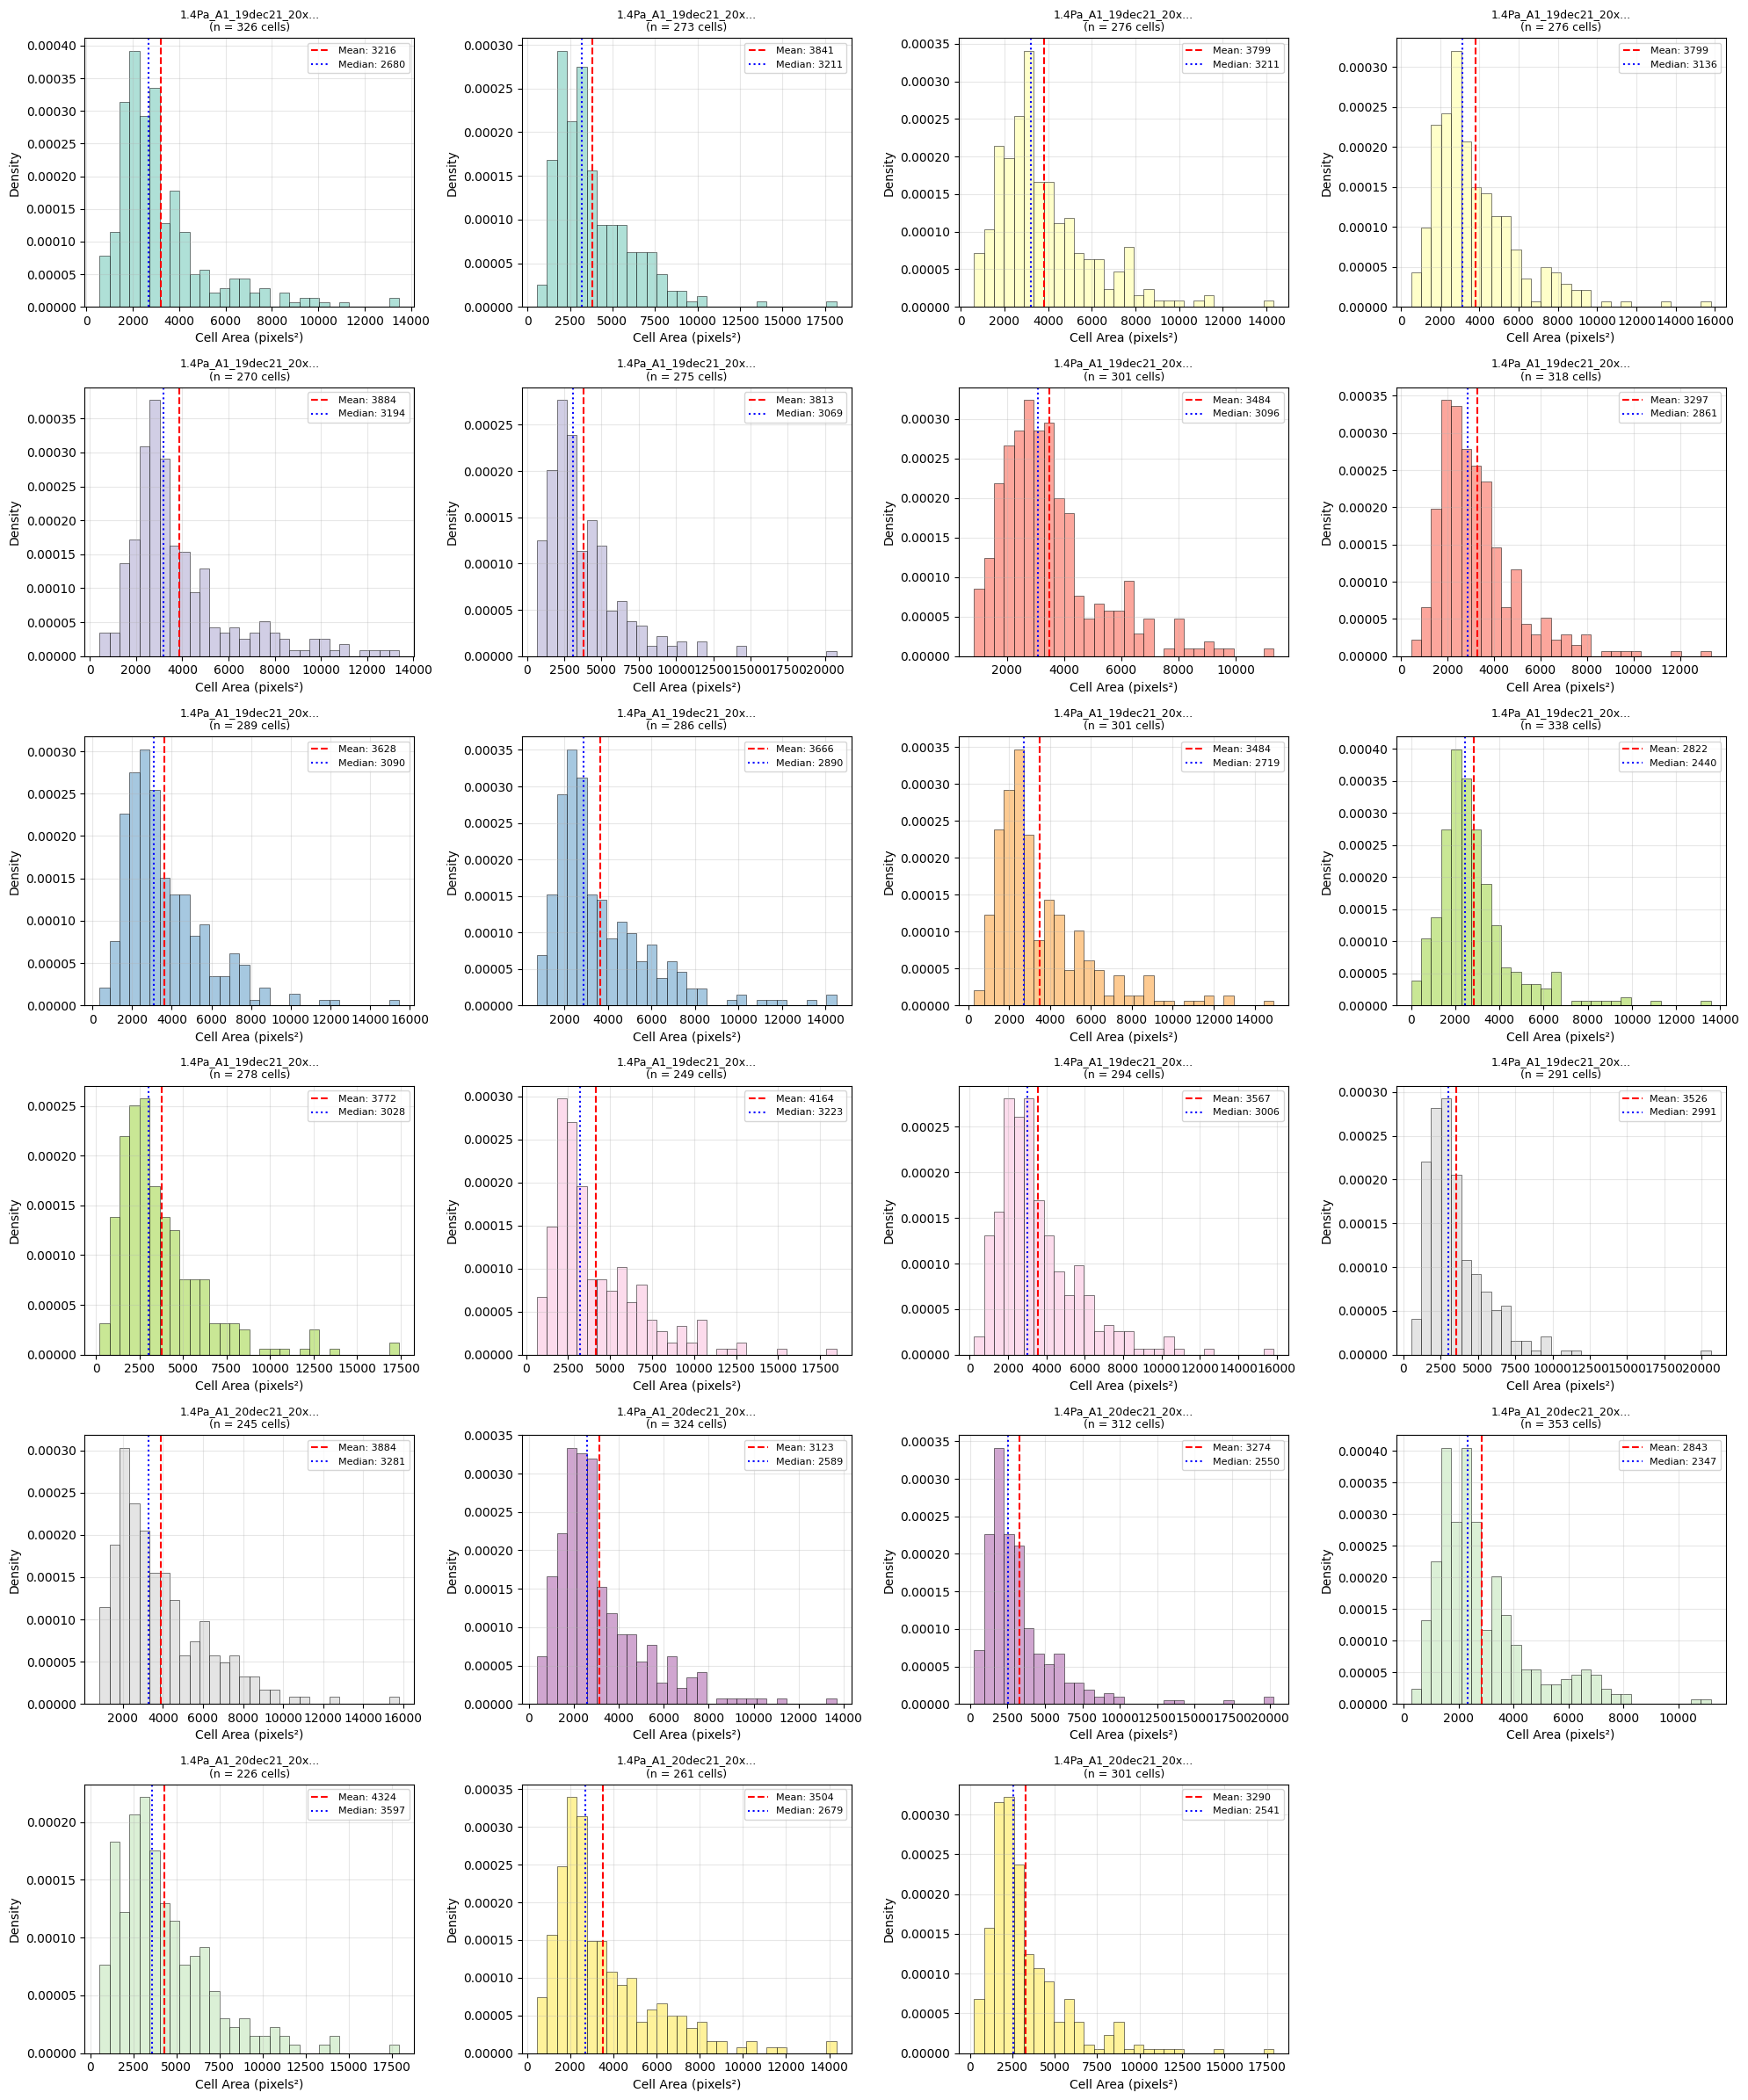

Individual image distributions saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/individual_image_cell_area_distributions_1p4pa_x20.png


/tmp/ipython-input-8-1657853895.py:178: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(valid_areas, labels=valid_labels, patch_artist=True)


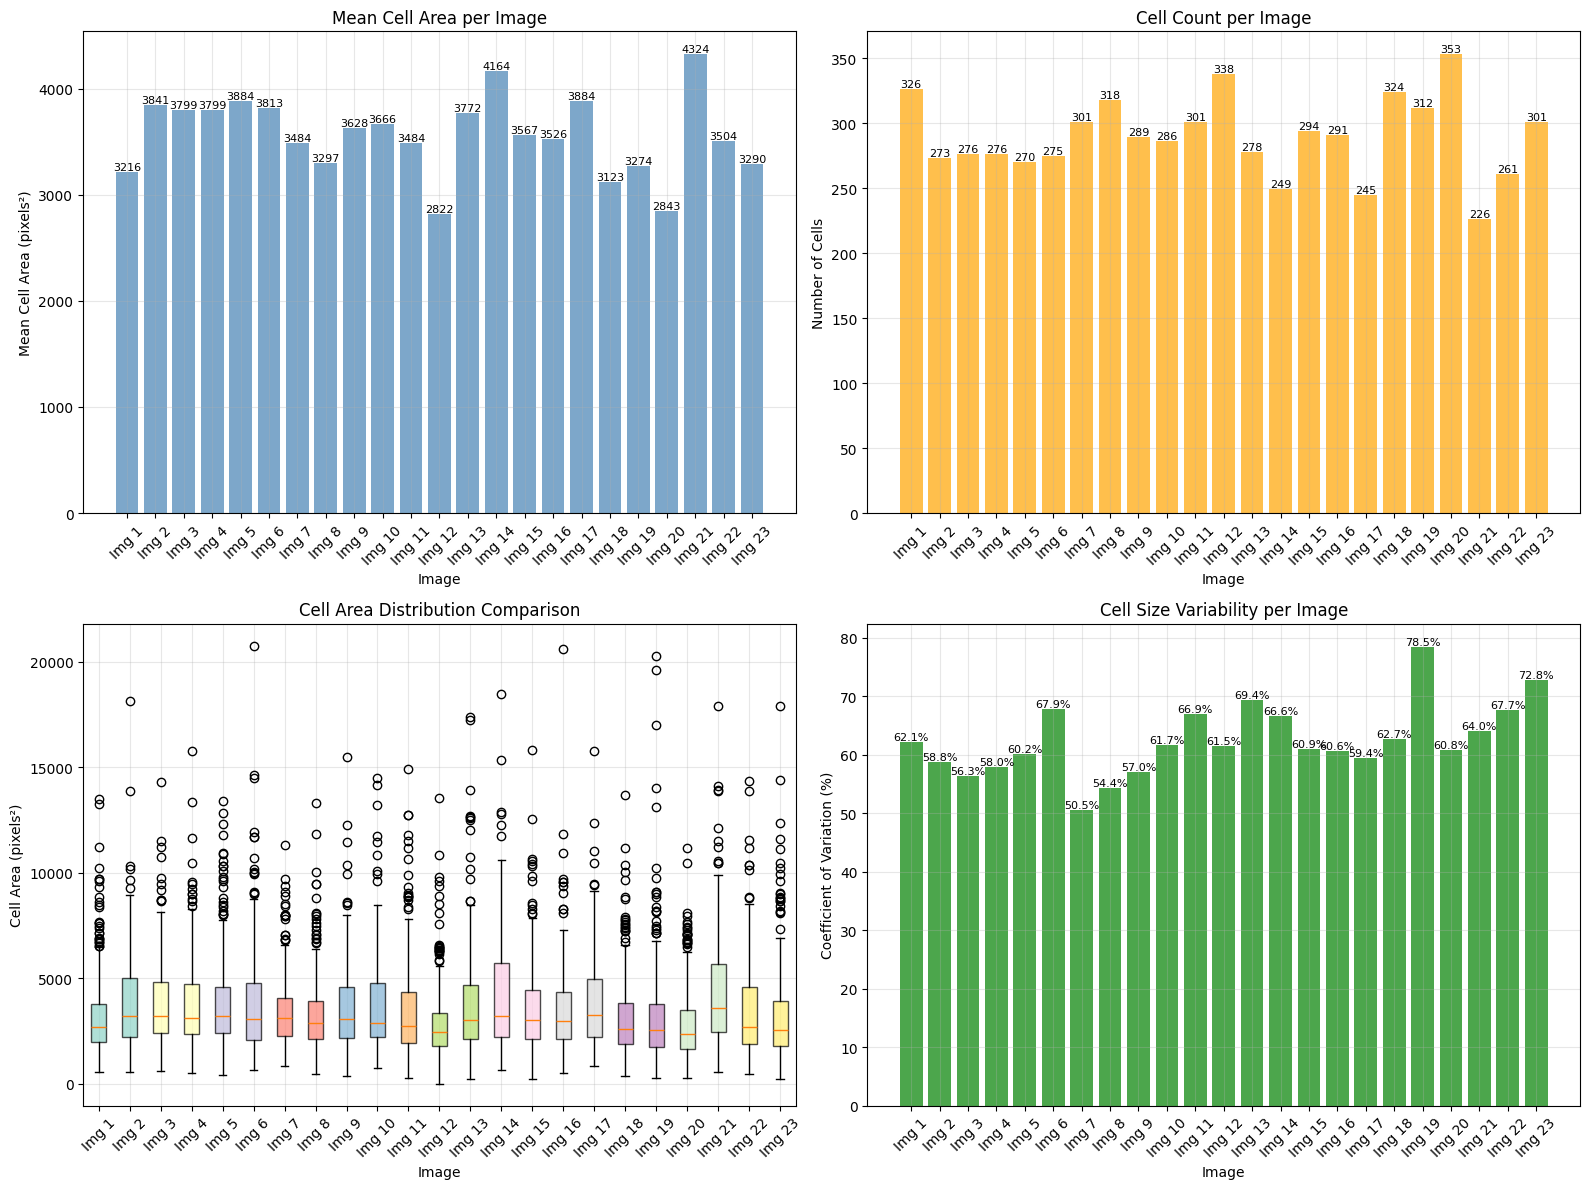

Summary comparison plots saved: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/summary_comparison_1p4pa_x20_images.png

DETAILED STATISTICS FOR EACH IMAGE

IMAGE 1: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_cell_mask_merged_conservative.tif
--------------------------------------------------
  Cell count: 326
  Mean area: 3216.5 pixels²
  Median area: 2680.5 pixels²
  Std deviation: 1997.3 pixels²
  Coefficient of variation: 62.1%
  Min area: 572 pixels²
  Max area: 13487 pixels²
  25th percentile: 1973.2 pixels²
  75th percentile: 3773.5 pixels²
  Interquartile range: 1800.2 pixels²
  Small cells (< Q1): 82 (25.2%)
  Large cells (> Q3): 82 (25.2%)

IMAGE 2: 1.4Pa_A1_19dec21_20xA_L2RA_FlatA_seq002_cell_mask_merged_conservative.tif
--------------------------------------------------
  Cell count: 273
  Mean area: 3840.9 pixels²
  Median area: 3211.0 pixels²
  Std deviation: 2256.8 pixels²
  Coefficient of variation: 58.8%
  Min area: 549 pixels²
  Max area: 18172 pixels

In [8]:
import pandas as pd
import numpy as np
import os
import glob
from google.colab import drive
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skimage.measure import regionprops
import math

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()

# Set up plotting style
plt.style.use('default')
plt.rcParams['font.size'] = 10

def extract_cell_areas_pixels(tif_path):
    """
    Extract individual cell areas from segmentation TIF file.
    Returns list of cell areas in PIXELS.
    """
    try:
        # Try reading with PIL first
        img = Image.open(tif_path)
        img_array = np.array(img)
    except Exception as e:
        try:
            # Fallback to OpenCV
            img_array = cv2.imread(tif_path, cv2.IMREAD_ANYDEPTH)
            if img_array is None:
                return None
        except Exception as e2:
            print(f"Error reading {tif_path}: {e}, {e2}")
            return None

    if img_array is None:
        return None

    try:
        # Use regionprops to measure individual cell areas
        regions = regionprops(img_array)

        # Extract areas in pixels (no conversion)
        cell_areas_pixels = [region.area for region in regions]

        return cell_areas_pixels

    except Exception as e:
        print(f"Error processing regions in {tif_path}: {e}")
        return None

def create_individual_image_distributions(image_data, base_path):
    """Create distribution plots for each individual image"""

    n_images = len(image_data)
    if n_images == 0:
        print("No image data to plot")
        return None

    # Calculate subplot grid
    n_cols = 4  # 4 images per row
    n_rows = math.ceil(n_images / n_cols)

    # Create large figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

    # Handle case where we have only one row
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_images > 1 else [axes]

    # Flatten axes for easier indexing
    if n_images > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    colors = plt.cm.Set3(np.linspace(0, 1, n_images))

    # Plot each image's distribution
    for i, (filename, areas) in enumerate(image_data.items()):
        ax = axes_flat[i]

        if len(areas) > 0:
            # Create histogram
            ax.hist(areas, bins=30, density=True, alpha=0.7, color=colors[i],
                   edgecolor='black', linewidth=0.5)

            # Add statistics lines
            mean_val = np.mean(areas)
            median_val = np.median(areas)
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5,
                      label=f'Mean: {mean_val:.0f}')
            ax.axvline(median_val, color='blue', linestyle=':', linewidth=1.5,
                      label=f'Median: {median_val:.0f}')

            # Formatting
            ax.set_xlabel('Cell Area (pixels²)')
            ax.set_ylabel('Density')
            ax.set_title(f'{filename[:20]}...\n(n = {len(areas)} cells)', fontsize=9)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No cells found', ha='center', va='center',
                   transform=ax.transAxes)
            ax.set_title(f'{filename[:20]}...', fontsize=9)

    # Hide empty subplots
    for i in range(n_images, len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(base_path, "individual_image_cell_area_distributions_1p4pa_x20.png")
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    plt.show()

    return plot_path

def create_summary_comparison_plot(image_data, base_path):
    """Create summary plots comparing all images"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Prepare data
    filenames = list(image_data.keys())
    areas_list = list(image_data.values())

    # Plot 1: Mean area per image
    means = [np.mean(areas) if len(areas) > 0 else 0 for areas in areas_list]
    x_pos = range(len(means))
    bars = ax1.bar(x_pos, means, alpha=0.7, color='steelblue')
    ax1.set_xlabel('Image')
    ax1.set_ylabel('Mean Cell Area (pixels²)')
    ax1.set_title('Mean Cell Area per Image')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'Img {i+1}' for i in x_pos], rotation=45)
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{mean_val:.0f}', ha='center', va='bottom', fontsize=8)

    # Plot 2: Cell count per image
    cell_counts = [len(areas) for areas in areas_list]
    bars2 = ax2.bar(x_pos, cell_counts, alpha=0.7, color='orange')
    ax2.set_xlabel('Image')
    ax2.set_ylabel('Number of Cells')
    ax2.set_title('Cell Count per Image')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'Img {i+1}' for i in x_pos], rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, count in zip(bars2, cell_counts):
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{count}', ha='center', va='bottom', fontsize=8)

    # Plot 3: Box plot comparison
    valid_areas = [areas for areas in areas_list if len(areas) > 0]
    valid_labels = [f'Img {i+1}' for i, areas in enumerate(areas_list) if len(areas) > 0]

    if len(valid_areas) > 0:
        bp = ax3.boxplot(valid_areas, labels=valid_labels, patch_artist=True)
        colors = plt.cm.Set3(np.linspace(0, 1, len(valid_areas)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

    ax3.set_xlabel('Image')
    ax3.set_ylabel('Cell Area (pixels²)')
    ax3.set_title('Cell Area Distribution Comparison')
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.get_xticklabels(), rotation=45)

    # Plot 4: Coefficient of variation
    cvs = []
    valid_image_names = []
    for i, areas in enumerate(areas_list):
        if len(areas) > 1:  # Need at least 2 cells to calculate CV
            cv = (np.std(areas) / np.mean(areas)) * 100
            cvs.append(cv)
            valid_image_names.append(f'Img {i+1}')

    if len(cvs) > 0:
        bars4 = ax4.bar(range(len(cvs)), cvs, alpha=0.7, color='green')
        ax4.set_xlabel('Image')
        ax4.set_ylabel('Coefficient of Variation (%)')
        ax4.set_title('Cell Size Variability per Image')
        ax4.set_xticks(range(len(cvs)))
        ax4.set_xticklabels(valid_image_names, rotation=45)
        ax4.grid(True, alpha=0.3)

        # Add value labels
        for bar, cv in zip(bars4, cvs):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{cv:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()

    # Save the plot
    summary_path = os.path.join(base_path, "summary_comparison_1p4pa_x20_images.png")
    plt.savefig(summary_path, dpi=200, bbox_inches='tight')
    plt.show()

    return summary_path

# Main analysis code - FOCUS ON 1.4Pa-x20 individual images
base_path = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/"
target_folder = "1.4Pa-x20"
subfolder_name = "Cell_merged_conservative"

print("Starting individual image cell area analysis for 1.4Pa-x20...")
print("="*60)

folder_path = os.path.join(base_path, target_folder, subfolder_name)
print(f"\nProcessing folder: {folder_path}")

if not os.path.exists(folder_path):
    print(f"Error: Path '{folder_path}' not found.")
    print("Please check that the folder exists.")
    exit()

tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))

if not tif_files:
    print(f"No TIF files found in {folder_path}")
    exit()

print(f"Found {len(tif_files)} TIF file(s)")

# Dictionary to store cell areas for each image
image_areas_data = {}

# Process each TIF file individually
for tif_file in tif_files:
    file_name = os.path.basename(tif_file)
    print(f"\nProcessing: {file_name}")

    cell_areas = extract_cell_areas_pixels(tif_file)

    if cell_areas is not None:
        image_areas_data[file_name] = cell_areas
        print(f"  Found {len(cell_areas)} cells")
        if len(cell_areas) > 0:
            print(f"  Mean area: {np.mean(cell_areas):.1f} pixels²")
            print(f"  Median area: {np.median(cell_areas):.1f} pixels²")
            print(f"  Min area: {np.min(cell_areas):.0f} pixels²")
            print(f"  Max area: {np.max(cell_areas):.0f} pixels²")
        else:
            print(f"  No cells detected in this image")
    else:
        print(f"  Failed to process {file_name}")
        image_areas_data[file_name] = []

# Create plots if we have data
if image_areas_data:
    print("\n" + "="*80)
    print("CREATING INDIVIDUAL IMAGE DISTRIBUTION PLOTS")
    print("="*80)

    # Create individual distributions plot
    plot1_path = create_individual_image_distributions(image_areas_data, base_path)
    print(f"Individual image distributions saved: {plot1_path}")

    # Create summary comparison plot
    plot2_path = create_summary_comparison_plot(image_areas_data, base_path)
    print(f"Summary comparison plots saved: {plot2_path}")

    # Print comprehensive statistics for each image
    print("\n" + "="*60)
    print("DETAILED STATISTICS FOR EACH IMAGE")
    print("="*60)

    all_areas = []  # To calculate overall statistics

    for i, (filename, areas) in enumerate(image_areas_data.items()):
        print(f"\nIMAGE {i+1}: {filename}")
        print("-" * 50)

        if len(areas) > 0:
            all_areas.extend(areas)

            print(f"  Cell count: {len(areas)}")
            print(f"  Mean area: {np.mean(areas):.1f} pixels²")
            print(f"  Median area: {np.median(areas):.1f} pixels²")
            print(f"  Std deviation: {np.std(areas):.1f} pixels²")
            print(f"  Coefficient of variation: {(np.std(areas)/np.mean(areas)*100):.1f}%")
            print(f"  Min area: {np.min(areas):.0f} pixels²")
            print(f"  Max area: {np.max(areas):.0f} pixels²")
            print(f"  25th percentile: {np.percentile(areas, 25):.1f} pixels²")
            print(f"  75th percentile: {np.percentile(areas, 75):.1f} pixels²")
            print(f"  Interquartile range: {np.percentile(areas, 75) - np.percentile(areas, 25):.1f} pixels²")

            # Size categories
            small_cells = len([a for a in areas if a < np.percentile(areas, 25)])
            large_cells = len([a for a in areas if a > np.percentile(areas, 75)])
            print(f"  Small cells (< Q1): {small_cells} ({small_cells/len(areas)*100:.1f}%)")
            print(f"  Large cells (> Q3): {large_cells} ({large_cells/len(areas)*100:.1f}%)")

        else:
            print(f"  No cells detected")

    # Overall statistics across all images
    if len(all_areas) > 0:
        print(f"\n" + "="*60)
        print("OVERALL STATISTICS (ALL IMAGES COMBINED)")
        print("="*60)

        print(f"\nTotal cells across all images: {len(all_areas):,}")
        print(f"Average cells per image: {len(all_areas)/len(image_areas_data):.1f}")
        print(f"Images processed: {len(image_areas_data)}")
        print(f"Images with cells: {len([areas for areas in image_areas_data.values() if len(areas) > 0])}")

        print(f"\nCombined area statistics:")
        print(f"  Overall mean: {np.mean(all_areas):.1f} pixels²")
        print(f"  Overall median: {np.median(all_areas):.1f} pixels²")
        print(f"  Overall std dev: {np.std(all_areas):.1f} pixels²")
        print(f"  Overall range: {np.max(all_areas) - np.min(all_areas):.0f} pixels²")

        # Image-to-image variability
        image_means = [np.mean(areas) for areas in image_areas_data.values() if len(areas) > 0]
        if len(image_means) > 1:
            print(f"\nImage-to-image variability:")
            print(f"  Mean of image means: {np.mean(image_means):.1f} pixels²")
            print(f"  Std dev between images: {np.std(image_means):.1f} pixels²")
            print(f"  CV between images: {(np.std(image_means)/np.mean(image_means)*100):.1f}%")

    print(f"\n" + "="*80)
    print("INDIVIDUAL IMAGE ANALYSIS COMPLETE")
    print("="*80)
    print("Plots created:")
    print(f"1. Individual image distributions: {plot1_path}")
    print(f"2. Summary comparisons: {plot2_path}")
    print(f"\nThis analysis shows the cell area distribution within each individual image")
    print(f"in the 1.4Pa-x20 condition, helping identify image-to-image variability.")

else:
    print("No cell area data found for any images.")
    print(f"Please check that TIF files exist in: {folder_path}")